# First Model Experiments

In this notebook I have made the first model experiments to have a baseline to start from. The objectives of this notebook are: 
* Deriving a data preparation procedure
* Define the models and metrics to use
* Track experiments and set up a model registry with MLFlow
* Saving a first draft of the models

In [38]:
import pandas as pd
import numpy as np

import matplotlib as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score, f1_score

import xgboost as xgb

import optuna

import mlflow
from mlflow.tracking import MlflowClient

import pickle

In [39]:
RANDOM_STATE = 2024

MLFLOW_TRACKING_URI = "sqlite:///../bank_churn.db"

In [40]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bank_churn_prediction")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/final_project/code/mlruns/1', creation_time=1721650927493, experiment_id='1', last_update_time=1721650927493, lifecycle_stage='active', name='bank_churn_prediction', tags={}>

To launch mlflow, execute the following command in your terminal: 

mlflow server --backend-store-uri sqlite:///bank_churn.db --default-artifact-root ./artifacts

### Data Preparation

In [41]:
data = pd.read_parquet('../data/customer_churn_records.parquet')

In [42]:
data.drop(['RowNumber','CustomerId','Surname'], 
          axis = 1, inplace = True)

categorical_variables = ['Geography', 'Gender', 'Card Type']
target = 'Exited'
isf_variables = ['Age','Complain','NumOfProducts'] 

data[categorical_variables] = data[categorical_variables].astype('category')

In [43]:
test_size = 0.2

train_data, val_data = train_test_split(data, test_size=test_size, random_state=RANDOM_STATE)


The following cell has only been used once to save data and it's not necessary to run it again. 


In [7]:
# train_data.to_parquet('../data/customer_churn_training_data.parquet', engine="pyarrow")
# val_data.to_parquet('../data/customer_churn_validation_data.parquet', engine="pyarrow")

### Model Experiments - Anomaly Detection

In [9]:
def objective_isf(trial):
    
    with mlflow.start_run(run_name = "anomaly_detection"):
        mlflow.set_tag("Project", "bank_churn_prediction")
        mlflow.set_tag("Developer", "Francesca")
        mlflow.set_tag("Model", "isolation_forest")
    
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 500, 10),
            'contamination': trial.suggest_discrete_uniform('contamination', 0.05, 0.5, 0.05),
            'max_features': trial.suggest_int('max_features', 1, 3),
            'bootstrap': True,
            'warm_start': True,
            'random_state': RANDOM_STATE
        }
        
        mlflow.log_params(params)

        isf = IsolationForest(**params)
        isf.fit(train_data[isf_variables])
        
        anomalies = isf.predict(val_data[isf_variables])
        
        pct_returning, pct_inliers = compute_isf_metrics(val_data, anomalies)
        score = (1 - pct_returning)*(1 - pct_inliers)
        
        mlflow.log_metric("pct_returning", pct_returning)
        mlflow.log_metric("pct_inliers", pct_inliers)
        mlflow.log_metric("score", score)
        
        mlflow.sklearn.log_model(isf, artifact_path="mlflow_models")
    
    return score

def compute_isf_metrics(val_data, anomalies):
    
    val_data['Anomalies'] = anomalies
    
    pct_returning = len(val_data[(val_data['Anomalies']==1) & (val_data[target]==0)])/len(val_data[val_data['Anomalies']==1])
    pct_inliers = len(val_data[val_data['Anomalies']==1])/len(anomalies)
    
    return pct_returning, pct_inliers

In [10]:
study_isf = optuna.create_study(direction='minimize') 
study_isf.optimize(objective_isf, n_trials=50) 

[I 2024-07-25 10:23:28,201] A new study created in memory with name: no-name-4262ba0c-c1cf-4b61-b842-0fba17a808a1
/tmp/ipykernel_6020/1685705441.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 500, 10),
/tmp/ipykernel_6020/1685705441.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'contamination': trial.suggest_discrete_uniform('contamination', 0.05, 0.5, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/codespace/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.


In [11]:
isf=IsolationForest(**study_isf.best_params)

isf.fit(train_data[isf_variables])

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.45, max_features=2, n_estimators=500)

In [12]:
# With these parameters found in a couple of trials I obtained the best score
# n_estimators=150, 
# max_samples='auto', 
# contamination=0.45,
# max_features=1.0,
# bootstrap = True, 
# warm_start = True,
# random_state=RANDOM_STATE

In [13]:
anomalies = isf.predict(val_data[isf_variables])

data_anom = val_data.copy()
data_anom['Anomalies'] = anomalies
data_anom

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned,Anomalies
8374,628,Spain,Female,55,7,0.00,3,1,0,85890.75,1,1,3,DIAMOND,791,-1
6935,670,France,Male,33,1,0.00,2,1,1,86413.11,0,0,3,DIAMOND,898,1
5103,783,Germany,Female,58,3,127539.30,1,1,1,96590.39,1,1,5,SILVER,270,-1
8963,741,France,Male,52,1,171236.30,2,0,0,21834.40,1,1,5,PLATINUM,332,-1
4993,554,France,Female,44,6,92436.86,1,1,0,126033.90,0,0,4,GOLD,938,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,702,Spain,Female,26,4,135219.57,1,0,1,59747.63,0,0,4,DIAMOND,267,-1
8073,777,Germany,Female,34,5,96693.66,1,1,1,172618.52,0,0,2,SILVER,971,1
3673,764,France,Male,24,7,98148.61,1,1,0,26843.76,0,0,1,GOLD,275,-1
8208,711,France,Female,29,3,130181.47,2,1,0,31811.44,0,0,5,SILVER,719,1


<AxesSubplot:xlabel='Exited', ylabel='Count'>

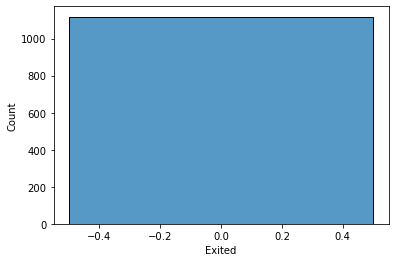

In [14]:
sns.histplot(data_anom[data_anom['Anomalies']==1][target], discrete=True)

<AxesSubplot:xlabel='Exited', ylabel='Count'>

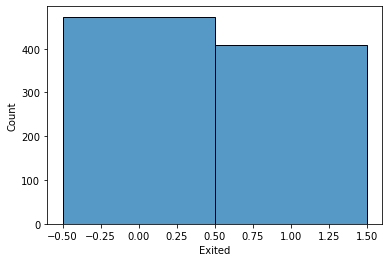

In [15]:
sns.histplot(data_anom[data_anom['Anomalies']==-1][target], discrete=True)

After applying anomaly detection, the dataset is not unbalanced anymore. Furthermore, we can already filter more than 40% of customers by setting a big chunk of returning customers on the side. 

<AxesSubplot:xlabel='Age', ylabel='Count'>

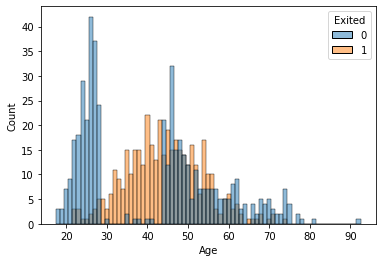

In [16]:
sns.histplot(data=data_anom[data_anom['Anomalies']==-1], x='Age', hue=target, discrete=True)

<AxesSubplot:xlabel='Age', ylabel='Count'>

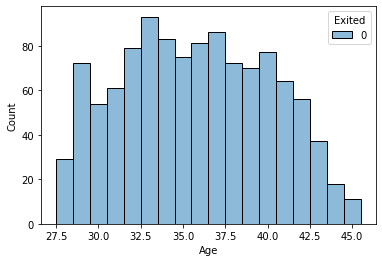

In [17]:
sns.histplot(data=data_anom[data_anom['Anomalies']==1], x='Age', hue=target, discrete=True)

<AxesSubplot:xlabel='NumOfProducts', ylabel='Count'>

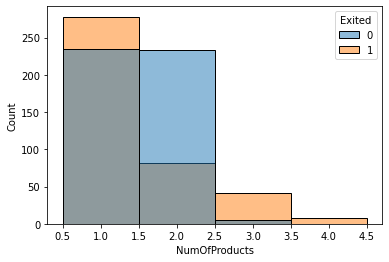

In [18]:
sns.histplot(data=data_anom[data_anom['Anomalies']==-1], x='NumOfProducts', hue=target, discrete=True)

<AxesSubplot:xlabel='NumOfProducts', ylabel='Count'>

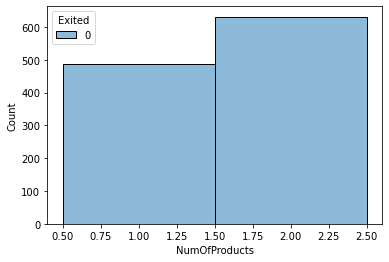

In [19]:
sns.histplot(data=data_anom[data_anom['Anomalies']==1], x='NumOfProducts', hue=target, discrete=True)

<AxesSubplot:xlabel='CreditScore', ylabel='Count'>

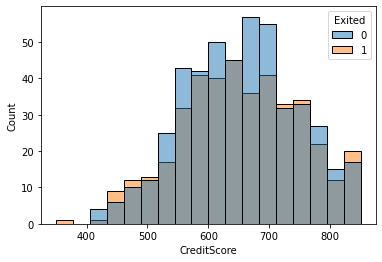

In [20]:
sns.histplot(data=data_anom[data_anom['Anomalies']==-1], x='CreditScore', hue=target)

<AxesSubplot:xlabel='CreditScore', ylabel='Count'>

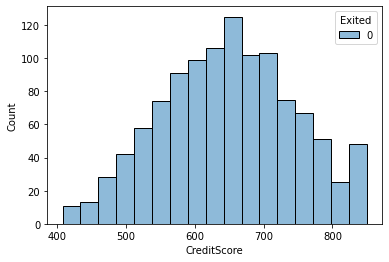

In [21]:
sns.histplot(data=data_anom[data_anom['Anomalies']==1], x='CreditScore', hue=target)

We can see how Isolation Forests also level out the most irregular distributions.

In [22]:
with open('../models/isolation_forest.bin', 'wb') as f_out:
    pickle.dump(isf, f_out)

In [23]:
mlflow.log_artifact("../models/isolation_forest.bin", artifact_path="isolation_forest")

In [24]:
client = MlflowClient("http://127.0.0.1:5000")
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1721651177461, description='', last_updated_timestamp=1721651499384, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1721651499384, current_stage='None', description='', last_updated_timestamp=1721651499384, name='isolation_forest', run_id='69e0a17554474392b877fa0ba5b70d21', run_link='', source='/workspaces/mlops-zoomcamp/final_project/code/mlruns/1/69e0a17554474392b877fa0ba5b70d21/artifacts/isolation_forest', status='READY', status_message='', tags={}, user_id='', version='1'>], name='isolation_forest', tags={}>,
 <RegisteredModel: aliases={}, creation_timestamp=1721651725153, description='', last_updated_timestamp=1721686807295, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1721686807295, current_stage='None', description='', last_updated_timestamp=1721686807295, name='xgboost', run_id='125bde922aef4e93a1a3ed09f96547bc', run_link='', source='/workspaces/mlops-zoomcamp/final_project/code/mlruns/1/125bde9

In [25]:
client.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops-zoomcamp/final_project/code/mlruns/1', creation_time=1721650927493, experiment_id='1', last_update_time=1721650927493, lifecycle_stage='active', name='bank_churn_prediction', tags={}>,
 <Experiment: artifact_location='/workspaces/mlops-zoomcamp/final_project/code/mlruns/0', creation_time=1721650927455, experiment_id='0', last_update_time=1721650927455, lifecycle_stage='active', name='Default', tags={}>]

In [26]:
study_isf.best_trial.number

0

In [27]:
study_isf.best_params

{'n_estimators': 500, 'contamination': 0.45, 'max_features': 2}

In [28]:
run_id = client.search_runs(experiment_ids=["1"])[50-study_isf.best_trial.number].info.run_id

In [29]:
#run_id = 'a81512e7ee184ef98b923cb89a712120' #Found on MLFlow UI

mlflow.register_model(
    model_uri=f"runs:/{run_id}/isolation_forest",
    name='isolation_forest'
)

Registered model 'isolation_forest' already exists. Creating a new version of this model...
Created version '2' of model 'isolation_forest'.


<ModelVersion: aliases=[], creation_timestamp=1721903196135, current_stage='None', description=None, last_updated_timestamp=1721903196135, name='isolation_forest', run_id='c8f028cf2e354471840a8fbc92ddbdb2', run_link=None, source='/workspaces/mlops-zoomcamp/final_project/code/mlruns/1/c8f028cf2e354471840a8fbc92ddbdb2/artifacts/isolation_forest', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [30]:
mlflow.end_run()

### Model Experiments - XGBoost

In [44]:
X_train = train_data.drop(target, axis=1)
y_train = train_data[target]

X_val = val_data.drop(target, axis=1)
y_val = val_data[target]

In [45]:
train_matrix = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
val_matrix = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

In [46]:
def objective_xgb(trial):
    
    with mlflow.start_run(run_name = "xgboost_classifier"):
        mlflow.set_tag("Project", "bank_churn_prediction")
        mlflow.set_tag("Developer", "Francesca")
        mlflow.set_tag("Model", "xgboost")
        
        params = {
            'objective': 'binary:logistic',
            'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
            'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
            'max_depth': trial.suggest_int('max_depth', 2, 100),
            'seed': RANDOM_STATE
        }
        
        mlflow.log_params(params)

        classifier = xgb.train(
                params = params,
                dtrain = train_matrix,
                num_boost_round = 1000,
                evals=[(val_matrix, 'validation')],
                early_stopping_rounds = 50
            )

        y_pred = np.rint(classifier.predict(val_matrix))

        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        mlflow.xgboost.log_model(classifier, artifact_path="mlflow_models")
    
    return recall 

In [47]:
study_xgb = optuna.create_study(direction='maximize') 
study_xgb.optimize(objective_xgb, n_trials=50) 

[I 2024-07-25 10:27:31,576] A new study created in memory with name: no-name-ed72d2f6-4038-473c-b53d-000782e54b9b
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
/tmp/ipykernel_6020/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),


[0]	validation-logloss:0.50579
[1]	validation-logloss:0.50253
[2]	validation-logloss:0.49931
[3]	validation-logloss:0.49612
[4]	validation-logloss:0.49297
[5]	validation-logloss:0.48986
[6]	validation-logloss:0.48679
[7]	validation-logloss:0.48375
[8]	validation-logloss:0.48076
[9]	validation-logloss:0.47781
[10]	validation-logloss:0.47488
[11]	validation-logloss:0.47198
[12]	validation-logloss:0.46912
[13]	validation-logloss:0.46629
[14]	validation-logloss:0.46350
[15]	validation-logloss:0.46073
[16]	validation-logloss:0.45799
[17]	validation-logloss:0.45528
[18]	validation-logloss:0.45259
[19]	validation-logloss:0.44993
[20]	validation-logloss:0.44731
[21]	validation-logloss:0.44470
[22]	validation-logloss:0.44212
[23]	validation-logloss:0.43957
[24]	validation-logloss:0.43704
[25]	validation-logloss:0.43453
[26]	validation-logloss:0.43205
[27]	validation-logloss:0.42959
[28]	validation-logloss:0.42717
[29]	validation-logloss:0.42476
[30]	validation-logloss:0.42237
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:27:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation-logloss:0.40406
[39]	validation-logloss:0.40186
[40]	validation-logloss:0.39968
[41]	validation-logloss:0.39753
[42]	validation-logloss:0.39539
[43]	validation-logloss:0.39327
[44]	validation-logloss:0.39116
[45]	validation-logloss:0.38907
[46]	validation-logloss:0.38700
[47]	validation-logloss:0.38494
[48]	validation-logloss:0.38291
[49]	validation-logloss:0.38090
[50]	validation-logloss:0.37889
[51]	validation-logloss:0.37691
[52]	validation-logloss:0.37493
[53]	validation-logloss:0.37298
[54]	validation-logloss:0.37104
[55]	validation-logloss:0.36912
[56]	validation-logloss:0.36721
[57]	validation-logloss:0.36532
[58]	validation-logloss:0.36345
[59]	validation-logloss:0.36159
[60]	validation-logloss:0.35973
[61]	validation-logloss:0.35789
[62]	validation-logloss:0.35607
[63]	validation-logloss:0.35426
[64]	validation-logloss:0.35247
[65]	validation-logloss:0.35069
[66]	validation-logloss:0.34892
[67]	validation-logloss:0.34717
[68]	validation-logloss:0.34543
[69]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:27:35] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:27:37,522] Trial 0 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 680, 'learning_rate': 0.0036781878741565938, 'subsample': 0.55, 'max_depth': 46}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., 

[0]	validation-logloss:0.49311
[1]	validation-logloss:0.47807
[2]	validation-logloss:0.46388
[3]	validation-logloss:0.45045
[4]	validation-logloss:0.43768
[5]	validation-logloss:0.42555
[6]	validation-logloss:0.41398
[7]	validation-logloss:0.40291
[8]	validation-logloss:0.39233
[9]	validation-logloss:0.38219
[10]	validation-logloss:0.37246
[11]	validation-logloss:0.36311
[12]	validation-logloss:0.35411
[13]	validation-logloss:0.34545
[14]	validation-logloss:0.33710
[15]	validation-logloss:0.32904
[16]	validation-logloss:0.32125
[17]	validation-logloss:0.31373
[18]	validation-logloss:0.30645
[19]	validation-logloss:0.29940
[20]	validation-logloss:0.29259
[21]	validation-logloss:0.28597
[22]	validation-logloss:0.27955
[23]	validation-logloss:0.27334
[24]	validation-logloss:0.26730
[25]	validation-logloss:0.26144
[26]	validation-logloss:0.25575
[27]	validation-logloss:0.25022
[28]	validation-logloss:0.24485
[29]	validation-logloss:0.23961
[30]	validation-logloss:0.23453
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:27:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[44]	validation-logloss:0.17574
[45]	validation-logloss:0.17227
[46]	validation-logloss:0.16889
[47]	validation-logloss:0.16559
[48]	validation-logloss:0.16237
[49]	validation-logloss:0.15922
[50]	validation-logloss:0.15614
[51]	validation-logloss:0.15313
[52]	validation-logloss:0.15019
[53]	validation-logloss:0.14732
[54]	validation-logloss:0.14450
[55]	validation-logloss:0.14176
[56]	validation-logloss:0.13907
[57]	validation-logloss:0.13645
[58]	validation-logloss:0.13389
[59]	validation-logloss:0.13137
[60]	validation-logloss:0.12892
[61]	validation-logloss:0.12652
[62]	validation-logloss:0.12417
[63]	validation-logloss:0.12188
[64]	validation-logloss:0.11962
[65]	validation-logloss:0.11742
[66]	validation-logloss:0.11526
[67]	validation-logloss:0.11316
[68]	validation-logloss:0.11109
[69]	validation-logloss:0.10907
[70]	validation-logloss:0.10709
[71]	validation-logloss:0.10516
[72]	validation-logloss:0.10326
[73]	validation-logloss:0.10141
[74]	validation-logloss:0.09960
[75]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:27:39] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:27:41,036] Trial 1 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 40, 'learning_rate': 0.017904772316388463, 'subsample': 0.9000000000000001, 'max_depth': 81}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.50563
[1]	validation-logloss:0.50222
[2]	validation-logloss:0.49883
[3]	validation-logloss:0.49550
[4]	validation-logloss:0.49220
[5]	validation-logloss:0.48895
[6]	validation-logloss:0.48575
[7]	validation-logloss:0.48257
[8]	validation-logloss:0.47945
[9]	validation-logloss:0.47637
[10]	validation-logloss:0.47333
[11]	validation-logloss:0.47030
[12]	validation-logloss:0.46731
[13]	validation-logloss:0.46436
[14]	validation-logloss:0.46145
[15]	validation-logloss:0.45858
[16]	validation-logloss:0.45573
[17]	validation-logloss:0.45291
[18]	validation-logloss:0.45011
[19]	validation-logloss:0.44735
[20]	validation-logloss:0.44463
[21]	validation-logloss:0.44192
[22]	validation-logloss:0.43924
[23]	validation-logloss:0.43660
[24]	validation-logloss:0.43397
[25]	validation-logloss:0.43138
[26]	validation-logloss:0.42881
[27]	validation-logloss:0.42627
[28]	validation-logloss:0.42375
[29]	validation-logloss:0.42125
[30]	validation-logloss:0.41879
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:27:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[52]	validation-logloss:0.36989
[53]	validation-logloss:0.36788
[54]	validation-logloss:0.36590
[55]	validation-logloss:0.36392
[56]	validation-logloss:0.36196
[57]	validation-logloss:0.36002
[58]	validation-logloss:0.35810
[59]	validation-logloss:0.35619
[60]	validation-logloss:0.35429
[61]	validation-logloss:0.35241
[62]	validation-logloss:0.35054
[63]	validation-logloss:0.34869
[64]	validation-logloss:0.34685
[65]	validation-logloss:0.34503
[66]	validation-logloss:0.34322
[67]	validation-logloss:0.34143
[68]	validation-logloss:0.33965
[69]	validation-logloss:0.33787
[70]	validation-logloss:0.33612
[71]	validation-logloss:0.33438
[72]	validation-logloss:0.33265
[73]	validation-logloss:0.33094
[74]	validation-logloss:0.32923
[75]	validation-logloss:0.32754
[76]	validation-logloss:0.32587
[77]	validation-logloss:0.32420
[78]	validation-logloss:0.32255
[79]	validation-logloss:0.32090
[80]	validation-logloss:0.31927
[81]	validation-logloss:0.31765
[82]	validation-logloss:0.31605
[83]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:27:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:27:46,595] Trial 2 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 230, 'learning_rate': 0.0038616393463135933, 'subsample': 0.45, 'max_depth': 79}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., 

[0]	validation-logloss:0.49704
[1]	validation-logloss:0.48548
[2]	validation-logloss:0.47445
[3]	validation-logloss:0.46393
[4]	validation-logloss:0.45378
[5]	validation-logloss:0.44399
[6]	validation-logloss:0.43466
[7]	validation-logloss:0.42560
[8]	validation-logloss:0.41690
[9]	validation-logloss:0.40847
[10]	validation-logloss:0.40032
[11]	validation-logloss:0.39241
[12]	validation-logloss:0.38470
[13]	validation-logloss:0.37725
[14]	validation-logloss:0.37009
[15]	validation-logloss:0.36313
[16]	validation-logloss:0.35635
[17]	validation-logloss:0.34977
[18]	validation-logloss:0.34333
[19]	validation-logloss:0.33710
[20]	validation-logloss:0.33099
[21]	validation-logloss:0.32505
[22]	validation-logloss:0.31925
[23]	validation-logloss:0.31362
[24]	validation-logloss:0.30814
[25]	validation-logloss:0.30276
[26]	validation-logloss:0.29754
[27]	validation-logloss:0.29240
[28]	validation-logloss:0.28739
[29]	validation-logloss:0.28252
[30]	validation-logloss:0.27778
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:27:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[54]	validation-logloss:0.18908
[55]	validation-logloss:0.18624
[56]	validation-logloss:0.18347
[57]	validation-logloss:0.18073
[58]	validation-logloss:0.17803
[59]	validation-logloss:0.17537
[60]	validation-logloss:0.17274
[61]	validation-logloss:0.17018
[62]	validation-logloss:0.16767
[63]	validation-logloss:0.16523
[64]	validation-logloss:0.16280
[65]	validation-logloss:0.16041
[66]	validation-logloss:0.15807
[67]	validation-logloss:0.15575
[68]	validation-logloss:0.15349
[69]	validation-logloss:0.15126
[70]	validation-logloss:0.14910
[71]	validation-logloss:0.14693
[72]	validation-logloss:0.14482
[73]	validation-logloss:0.14276
[74]	validation-logloss:0.14072
[75]	validation-logloss:0.13873
[76]	validation-logloss:0.13674
[77]	validation-logloss:0.13477
[78]	validation-logloss:0.13287
[79]	validation-logloss:0.13097
[80]	validation-logloss:0.12912
[81]	validation-logloss:0.12734
[82]	validation-logloss:0.12556
[83]	validation-logloss:0.12382
[84]	validation-logloss:0.12209
[85]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:27:49] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:27:51,004] Trial 3 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 560, 'learning_rate': 0.013592892396939053, 'subsample': 0.2, 'max_depth': 91}. Best is trial 0 with value: 0.9975550122249389.


[0]	validation-logloss:0.50352


/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
/tmp/ipykernel_6020/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:27:51] WARNING: /workspace/src/learner.cc:

[1]	validation-logloss:0.49805
[2]	validation-logloss:0.49272
[3]	validation-logloss:0.48752
[4]	validation-logloss:0.48240
[5]	validation-logloss:0.47736
[6]	validation-logloss:0.47247
[7]	validation-logloss:0.46765
[8]	validation-logloss:0.46294
[9]	validation-logloss:0.45828
[10]	validation-logloss:0.45371
[11]	validation-logloss:0.44922
[12]	validation-logloss:0.44477
[13]	validation-logloss:0.44042
[14]	validation-logloss:0.43615
[15]	validation-logloss:0.43198
[16]	validation-logloss:0.42783
[17]	validation-logloss:0.42379
[18]	validation-logloss:0.41978
[19]	validation-logloss:0.41584
[20]	validation-logloss:0.41196
[21]	validation-logloss:0.40814
[22]	validation-logloss:0.40435
[23]	validation-logloss:0.40064
[24]	validation-logloss:0.39699
[25]	validation-logloss:0.39339
[26]	validation-logloss:0.38984
[27]	validation-logloss:0.38632
[28]	validation-logloss:0.38286
[29]	validation-logloss:0.37946
[30]	validation-logloss:0.37613
[31]	validation-logloss:0.37283
[32]	validation-l

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:27:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:27:56,079] Trial 4 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 970, 'learning_rate': 0.006273293287187778, 'subsample': 0.15000000000000002, 'max_depth': 9}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

[0]	validation-logloss:0.50731
[1]	validation-logloss:0.50555
[2]	validation-logloss:0.50379
[3]	validation-logloss:0.50205
[4]	validation-logloss:0.50031
[5]	validation-logloss:0.49859
[6]	validation-logloss:0.49688
[7]	validation-logloss:0.49518
[8]	validation-logloss:0.49350
[9]	validation-logloss:0.49182
[10]	validation-logloss:0.49016
[11]	validation-logloss:0.48851
[12]	validation-logloss:0.48686
[13]	validation-logloss:0.48523
[14]	validation-logloss:0.48361
[15]	validation-logloss:0.48200
[16]	validation-logloss:0.48039
[17]	validation-logloss:0.47880
[18]	validation-logloss:0.47721
[19]	validation-logloss:0.47564
[20]	validation-logloss:0.47408
[21]	validation-logloss:0.47252
[22]	validation-logloss:0.47097
[23]	validation-logloss:0.46943
[24]	validation-logloss:0.46791
[25]	validation-logloss:0.46638
[26]	validation-logloss:0.46487
[27]	validation-logloss:0.46337
[28]	validation-logloss:0.46188
[29]	validation-logloss:0.46039
[30]	validation-logloss:0.45892
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:27:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[47]	validation-logloss:0.43504
[48]	validation-logloss:0.43370
[49]	validation-logloss:0.43237
[50]	validation-logloss:0.43105
[51]	validation-logloss:0.42973
[52]	validation-logloss:0.42842
[53]	validation-logloss:0.42711
[54]	validation-logloss:0.42582
[55]	validation-logloss:0.42453
[56]	validation-logloss:0.42324
[57]	validation-logloss:0.42197
[58]	validation-logloss:0.42070
[59]	validation-logloss:0.41943
[60]	validation-logloss:0.41818
[61]	validation-logloss:0.41692
[62]	validation-logloss:0.41567
[63]	validation-logloss:0.41444
[64]	validation-logloss:0.41320
[65]	validation-logloss:0.41198
[66]	validation-logloss:0.41075
[67]	validation-logloss:0.40954
[68]	validation-logloss:0.40833
[69]	validation-logloss:0.40712
[70]	validation-logloss:0.40593
[71]	validation-logloss:0.40474
[72]	validation-logloss:0.40355
[73]	validation-logloss:0.40237
[74]	validation-logloss:0.40119
[75]	validation-logloss:0.40002
[76]	validation-logloss:0.39886
[77]	validation-logloss:0.39770
[78]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:27:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:01,234] Trial 5 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 280, 'learning_rate': 0.001977638542142825, 'subsample': 0.7000000000000001, 'max_depth': 45}. Best is trial 0 with value: 0.9975550122249389.


[0]	validation-logloss:0.36135
[1]	validation-logloss:0.27880


/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
/tmp/ipykernel_6020/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:01] WARNING: /workspace/src/learner.cc:

[2]	validation-logloss:0.22147
[3]	validation-logloss:0.17903
[4]	validation-logloss:0.14608
[5]	validation-logloss:0.11995
[6]	validation-logloss:0.09961
[7]	validation-logloss:0.08300
[8]	validation-logloss:0.06995
[9]	validation-logloss:0.05919
[10]	validation-logloss:0.05049
[11]	validation-logloss:0.04325
[12]	validation-logloss:0.03703
[13]	validation-logloss:0.03216
[14]	validation-logloss:0.02832
[15]	validation-logloss:0.02501
[16]	validation-logloss:0.02237
[17]	validation-logloss:0.02030
[18]	validation-logloss:0.01844
[19]	validation-logloss:0.01707
[20]	validation-logloss:0.01573
[21]	validation-logloss:0.01475
[22]	validation-logloss:0.01392
[23]	validation-logloss:0.01328
[24]	validation-logloss:0.01279
[25]	validation-logloss:0.01232
[26]	validation-logloss:0.01197
[27]	validation-logloss:0.01155
[28]	validation-logloss:0.01132
[29]	validation-logloss:0.01119
[30]	validation-logloss:0.01117
[31]	validation-logloss:0.01109
[32]	validation-logloss:0.01100
[33]	validation-

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:01] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:03,547] Trial 6 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 780, 'learning_rate': 0.18360348699190637, 'subsample': 0.2, 'max_depth': 43}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.50734
[1]	validation-logloss:0.50561
[2]	validation-logloss:0.50389
[3]	validation-logloss:0.50220
[4]	validation-logloss:0.50053
[5]	validation-logloss:0.49885
[6]	validation-logloss:0.49717
[7]	validation-logloss:0.49552
[8]	validation-logloss:0.49386
[9]	validation-logloss:0.49223
[10]	validation-logloss:0.49060
[11]	validation-logloss:0.48898
[12]	validation-logloss:0.48736
[13]	validation-logloss:0.48576
[14]	validation-logloss:0.48416
[15]	validation-logloss:0.48263
[16]	validation-logloss:0.48104
[17]	validation-logloss:0.47950
[18]	validation-logloss:0.47794
[19]	validation-logloss:0.47640
[20]	validation-logloss:0.47486
[21]	validation-logloss:0.47333
[22]	validation-logloss:0.47181
[23]	validation-logloss:0.47029
[24]	validation-logloss:0.46880
[25]	validation-logloss:0.46731
[26]	validation-logloss:0.46584
[27]	validation-logloss:0.46436
[28]	validation-logloss:0.46288
[29]	validation-logloss:0.46143
[30]	validation-logloss:0.46003
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[70]	validation-logloss:0.40773
[71]	validation-logloss:0.40653
[72]	validation-logloss:0.40535
[73]	validation-logloss:0.40417
[74]	validation-logloss:0.40300
[75]	validation-logloss:0.40184
[76]	validation-logloss:0.40068
[77]	validation-logloss:0.39953
[78]	validation-logloss:0.39838
[79]	validation-logloss:0.39723
[80]	validation-logloss:0.39609
[81]	validation-logloss:0.39496
[82]	validation-logloss:0.39384
[83]	validation-logloss:0.39273
[84]	validation-logloss:0.39163
[85]	validation-logloss:0.39054
[86]	validation-logloss:0.38943
[87]	validation-logloss:0.38832
[88]	validation-logloss:0.38723
[89]	validation-logloss:0.38615
[90]	validation-logloss:0.38505
[91]	validation-logloss:0.38398
[92]	validation-logloss:0.38292
[93]	validation-logloss:0.38185
[94]	validation-logloss:0.38078
[95]	validation-logloss:0.37970
[96]	validation-logloss:0.37864
[97]	validation-logloss:0.37760
[98]	validation-logloss:0.37659
[99]	validation-logloss:0.37553
[100]	validation-logloss:0.37449
[101]	v

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:08,528] Trial 7 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 860, 'learning_rate': 0.002020143298118712, 'subsample': 0.05, 'max_depth': 5}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[0]	validation-logloss:0.50433
[1]	validation-logloss:0.49965
[2]	validation-logloss:0.49505
[3]	validation-logloss:0.49054
[4]	validation-logloss:0.48609
[5]	validation-logloss:0.48173
[6]	validation-logloss:0.47744
[7]	validation-logloss:0.47321
[8]	validation-logloss:0.46906
[9]	validation-logloss:0.46497
[10]	validation-logloss:0.46095
[11]	validation-logloss:0.45699
[12]	validation-logloss:0.45309
[13]	validation-logloss:0.44925
[14]	validation-logloss:0.44546
[15]	validation-logloss:0.44173
[16]	validation-logloss:0.43806
[17]	validation-logloss:0.43443
[18]	validation-logloss:0.43086
[19]	validation-logloss:0.42734
[20]	validation-logloss:0.42386
[21]	validation-logloss:0.42043
[22]	validation-logloss:0.41705
[23]	validation-logloss:0.41371
[24]	validation-logloss:0.41041
[25]	validation-logloss:0.40716
[26]	validation-logloss:0.40395
[27]	validation-logloss:0.40078
[28]	validation-logloss:0.39765
[29]	validation-logloss:0.39456
[30]	validation-logloss:0.39151
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[70]	validation-logloss:0.29348
[71]	validation-logloss:0.29150
[72]	validation-logloss:0.28954
[73]	validation-logloss:0.28760
[74]	validation-logloss:0.28567
[75]	validation-logloss:0.28376
[76]	validation-logloss:0.28187
[77]	validation-logloss:0.27999
[78]	validation-logloss:0.27814
[79]	validation-logloss:0.27629
[80]	validation-logloss:0.27446
[81]	validation-logloss:0.27266
[82]	validation-logloss:0.27086
[83]	validation-logloss:0.26908
[84]	validation-logloss:0.26732
[85]	validation-logloss:0.26557
[86]	validation-logloss:0.26384
[87]	validation-logloss:0.26213
[88]	validation-logloss:0.26042
[89]	validation-logloss:0.25873
[90]	validation-logloss:0.25706
[91]	validation-logloss:0.25540
[92]	validation-logloss:0.25375
[93]	validation-logloss:0.25212
[94]	validation-logloss:0.25050
[95]	validation-logloss:0.24889
[96]	validation-logloss:0.24730
[97]	validation-logloss:0.24572
[98]	validation-logloss:0.24416
[99]	validation-logloss:0.24260
[100]	validation-logloss:0.24106
[101]	v

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:13,674] Trial 8 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 360, 'learning_rate': 0.005302876716582012, 'subsample': 0.9000000000000001, 'max_depth': 91}. Best is trial 0 with value: 0.9975550122249389.


[0]	validation-logloss:0.49697
[1]	validation-logloss:0.48540
[2]	validation-logloss:0.47432
[3]	validation-logloss:0.46371
[4]	validation-logloss:0.45352
[5]	validation-logloss:0.44373
[6]	validation-logloss:0.43432
[7]	validation-logloss:0.42521
[8]	validation-logloss:0.41645
[9]	validation-logloss:0.40800
[10]	validation-logloss:0.39982
[11]	validation-logloss:0.39189
[12]	validation-logloss:0.38422
[13]	validation-logloss:0.37679
[14]	validation-logloss:0.36958
[15]	validation-logloss:0.36258
[16]	validation-logloss:0.35577
[17]	validation-logloss:0.34915
[18]	validation-logloss:0.34270
[19]	validation-logloss:0.33643
[20]	validation-logloss:0.33034
[21]	validation-logloss:0.32439
[22]	validation-logloss:0.31859
[23]	validation-logloss:0.31296
[24]	validation-logloss:0.30745
[25]	validation-logloss:0.30208
[26]	validation-logloss:0.29684
[27]	validation-logloss:0.29172
[28]	validation-logloss:0.28673
[29]	validation-logloss:0.28185
[30]	validation-logloss:0.27708
[31]	validation-lo

/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
/tmp/ipykernel_6020/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:13] WARNING: /workspace/src/learner.cc:

[60]	validation-logloss:0.17205
[61]	validation-logloss:0.16949
[62]	validation-logloss:0.16697
[63]	validation-logloss:0.16451
[64]	validation-logloss:0.16208
[65]	validation-logloss:0.15969
[66]	validation-logloss:0.15734
[67]	validation-logloss:0.15505
[68]	validation-logloss:0.15279
[69]	validation-logloss:0.15056
[70]	validation-logloss:0.14838
[71]	validation-logloss:0.14623
[72]	validation-logloss:0.14411
[73]	validation-logloss:0.14204
[74]	validation-logloss:0.14000
[75]	validation-logloss:0.13799
[76]	validation-logloss:0.13602
[77]	validation-logloss:0.13408
[78]	validation-logloss:0.13217
[79]	validation-logloss:0.13029
[80]	validation-logloss:0.12845
[81]	validation-logloss:0.12663
[82]	validation-logloss:0.12486
[83]	validation-logloss:0.12310
[84]	validation-logloss:0.12137
[85]	validation-logloss:0.11967
[86]	validation-logloss:0.11800
[87]	validation-logloss:0.11636
[88]	validation-logloss:0.11474
[89]	validation-logloss:0.11315
[90]	validation-logloss:0.11158
[91]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:16] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:17,956] Trial 9 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 880, 'learning_rate': 0.013548661912477632, 'subsample': 0.8, 'max_depth': 90}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[0]	validation-logloss:0.41826
[1]	validation-logloss:0.35488
[2]	validation-logloss:0.30567
[3]	validation-logloss:0.26591
[4]	validation-logloss:0.23287
[5]	validation-logloss:0.20499
[6]	validation-logloss:0.18135
[7]	validation-logloss:0.16084
[8]	validation-logloss:0.14317
[9]	validation-logloss:0.12788
[10]	validation-logloss:0.11444
[11]	validation-logloss:0.10255
[12]	validation-logloss:0.09210
[13]	validation-logloss:0.08287
[14]	validation-logloss:0.07480
[15]	validation-logloss:0.06764
[16]	validation-logloss:0.06121
[17]	validation-logloss:0.05550
[18]	validation-logloss:0.05041
[19]	validation-logloss:0.04586
[20]	validation-logloss:0.04193
[21]	validation-logloss:0.03826
[22]	validation-logloss:0.03508
[23]	validation-logloss:0.03236
[24]	validation-logloss:0.02983
[25]	validation-logloss:0.02760
[26]	validation-logloss:0.02554
[27]	validation-logloss:0.02376
[28]	validation-logloss:0.02222
[29]	validation-logloss:0.02082
[30]	validation-logloss:0.01958
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[43]	validation-logloss:0.01173
[44]	validation-logloss:0.01152
[45]	validation-logloss:0.01126
[46]	validation-logloss:0.01116
[47]	validation-logloss:0.01105
[48]	validation-logloss:0.01091
[49]	validation-logloss:0.01086
[50]	validation-logloss:0.01081
[51]	validation-logloss:0.01071
[52]	validation-logloss:0.01065
[53]	validation-logloss:0.01052
[54]	validation-logloss:0.01049
[55]	validation-logloss:0.01037
[56]	validation-logloss:0.01036
[57]	validation-logloss:0.01034
[58]	validation-logloss:0.01034
[59]	validation-logloss:0.01037
[60]	validation-logloss:0.01028
[61]	validation-logloss:0.01014
[62]	validation-logloss:0.01017
[63]	validation-logloss:0.01024
[64]	validation-logloss:0.01026
[65]	validation-logloss:0.01030
[66]	validation-logloss:0.01029
[67]	validation-logloss:0.01027
[68]	validation-logloss:0.01019
[69]	validation-logloss:0.01020
[70]	validation-logloss:0.01013
[71]	validation-logloss:0.01018
[72]	validation-logloss:0.01020
[73]	validation-logloss:0.01024
[74]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:18] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:20,477] Trial 10 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 640, 'learning_rate': 0.10688910567694146, 'subsample': 0.5, 'max_depth': 28}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[0]	validation-logloss:0.46549
[1]	validation-logloss:0.42866
[2]	validation-logloss:0.39677
[3]	validation-logloss:0.36868
[4]	validation-logloss:0.34362
[5]	validation-logloss:0.32106
[6]	validation-logloss:0.30059
[7]	validation-logloss:0.28192
[8]	validation-logloss:0.26481
[9]	validation-logloss:0.24905
[10]	validation-logloss:0.23451
[11]	validation-logloss:0.22104
[12]	validation-logloss:0.20854
[13]	validation-logloss:0.19690
[14]	validation-logloss:0.18606
[15]	validation-logloss:0.17596
[16]	validation-logloss:0.16650
[17]	validation-logloss:0.15766
[18]	validation-logloss:0.14936
[19]	validation-logloss:0.14158
[20]	validation-logloss:0.13428
[21]	validation-logloss:0.12741
[22]	validation-logloss:0.12096
[23]	validation-logloss:0.11488
[24]	validation-logloss:0.10915
[25]	validation-logloss:0.10376
[26]	validation-logloss:0.09868
[27]	validation-logloss:0.09388
[28]	validation-logloss:0.08935
[29]	validation-logloss:0.08508
[30]	validation-logloss:0.08104
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[47]	validation-logloss:0.03760
[48]	validation-logloss:0.03608
[49]	validation-logloss:0.03464
[50]	validation-logloss:0.03327
[51]	validation-logloss:0.03196
[52]	validation-logloss:0.03073
[53]	validation-logloss:0.02959
[54]	validation-logloss:0.02848
[55]	validation-logloss:0.02743
[56]	validation-logloss:0.02646
[57]	validation-logloss:0.02552
[58]	validation-logloss:0.02465
[59]	validation-logloss:0.02380
[60]	validation-logloss:0.02299
[61]	validation-logloss:0.02225
[62]	validation-logloss:0.02150
[63]	validation-logloss:0.02081
[64]	validation-logloss:0.02013
[65]	validation-logloss:0.01954
[66]	validation-logloss:0.01897
[67]	validation-logloss:0.01841
[68]	validation-logloss:0.01790
[69]	validation-logloss:0.01743
[70]	validation-logloss:0.01698
[71]	validation-logloss:0.01654
[72]	validation-logloss:0.01613
[73]	validation-logloss:0.01576
[74]	validation-logloss:0.01536
[75]	validation-logloss:0.01503
[76]	validation-logloss:0.01471
[77]	validation-logloss:0.01440
[78]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:21] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:23,123] Trial 11 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 100, 'learning_rate': 0.04961837436033459, 'subsample': 1.0, 'max_depth': 69}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[0]	validation-logloss:0.11603
[1]	validation-logloss:0.05504
[2]	validation-logloss:0.02923
[3]	validation-logloss:0.01790
[4]	validation-logloss:0.01303
[5]	validation-logloss:0.01151
[6]	validation-logloss:0.01128
[7]	validation-logloss:0.01095
[8]	validation-logloss:0.01170
[9]	validation-logloss:0.01102
[10]	validation-logloss:0.01160
[11]	validation-logloss:0.01183
[12]	validation-logloss:0.01200
[13]	validation-logloss:0.01215
[14]	validation-logloss:0.01277
[15]	validation-logloss:0.01313
[16]	validation-logloss:0.01312
[17]	validation-logloss:0.01286
[18]	validation-logloss:0.01331
[19]	validation-logloss:0.01343
[20]	validation-logloss:0.01303
[21]	validation-logloss:0.01319
[22]	validation-logloss:0.01262
[23]	validation-logloss:0.01233
[24]	validation-logloss:0.01176
[25]	validation-logloss:0.01235
[26]	validation-logloss:0.01255
[27]	validation-logloss:0.01282
[28]	validation-logloss:0.01244
[29]	validation-logloss:0.01299
[30]	validation-logloss:0.01320
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[42]	validation-logloss:0.01348
[43]	validation-logloss:0.01341
[44]	validation-logloss:0.01344
[45]	validation-logloss:0.01383
[46]	validation-logloss:0.01390
[47]	validation-logloss:0.01383
[48]	validation-logloss:0.01379
[49]	validation-logloss:0.01391
[50]	validation-logloss:0.01397
[51]	validation-logloss:0.01388
[52]	validation-logloss:0.01409
[53]	validation-logloss:0.01425
[54]	validation-logloss:0.01447
[55]	validation-logloss:0.01445
[56]	validation-logloss:0.01448


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:25,403] Trial 12 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 420, 'learning_rate': 0.7510268475850159, 'subsample': 0.7000000000000001, 'max_depth': 64}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.49324
[1]	validation-logloss:0.47838
[2]	validation-logloss:0.46428
[3]	validation-logloss:0.45093
[4]	validation-logloss:0.43825
[5]	validation-logloss:0.42614
[6]	validation-logloss:0.41470
[7]	validation-logloss:0.40369
[8]	validation-logloss:0.39320
[9]	validation-logloss:0.38319
[10]	validation-logloss:0.37355
[11]	validation-logloss:0.36422
[12]	validation-logloss:0.35524
[13]	validation-logloss:0.34660
[14]	validation-logloss:0.33832
[15]	validation-logloss:0.33030
[16]	validation-logloss:0.32256
[17]	validation-logloss:0.31505
[18]	validation-logloss:0.30778
[19]	validation-logloss:0.30077
[20]	validation-logloss:0.29399
[21]	validation-logloss:0.28737
[22]	validation-logloss:0.28097
[23]	validation-logloss:0.27477
[24]	validation-logloss:0.26875
[25]	validation-logloss:0.26288
[26]	validation-logloss:0.25722
[27]	validation-logloss:0.25168
[28]	validation-logloss:0.24631
[29]	validation-logloss:0.24109
[30]	validation-logloss:0.23601
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[43]	validation-logloss:0.18081
[44]	validation-logloss:0.17725
[45]	validation-logloss:0.17376
[46]	validation-logloss:0.17038
[47]	validation-logloss:0.16706
[48]	validation-logloss:0.16381
[49]	validation-logloss:0.16065
[50]	validation-logloss:0.15758
[51]	validation-logloss:0.15457
[52]	validation-logloss:0.15161
[53]	validation-logloss:0.14872
[54]	validation-logloss:0.14592
[55]	validation-logloss:0.14316
[56]	validation-logloss:0.14047
[57]	validation-logloss:0.13785
[58]	validation-logloss:0.13528
[59]	validation-logloss:0.13279
[60]	validation-logloss:0.13030
[61]	validation-logloss:0.12790
[62]	validation-logloss:0.12554
[63]	validation-logloss:0.12325
[64]	validation-logloss:0.12099
[65]	validation-logloss:0.11877
[66]	validation-logloss:0.11659
[67]	validation-logloss:0.11449
[68]	validation-logloss:0.11243
[69]	validation-logloss:0.11039
[70]	validation-logloss:0.10841
[71]	validation-logloss:0.10649
[72]	validation-logloss:0.10459
[73]	validation-logloss:0.10274
[74]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:27] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:29,589] Trial 13 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 80, 'learning_rate': 0.017791223185698837, 'subsample': 0.4, 'max_depth': 60}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[0]	validation-logloss:0.47148
[1]	validation-logloss:0.43895
[2]	validation-logloss:0.41027
[3]	validation-logloss:0.38464
[4]	validation-logloss:0.36148
[5]	validation-logloss:0.34047
[6]	validation-logloss:0.32127
[7]	validation-logloss:0.30353
[8]	validation-logloss:0.28721
[9]	validation-logloss:0.27211
[10]	validation-logloss:0.25804
[11]	validation-logloss:0.24489
[12]	validation-logloss:0.23260
[13]	validation-logloss:0.22113
[14]	validation-logloss:0.21037
[15]	validation-logloss:0.20025
[16]	validation-logloss:0.19072
[17]	validation-logloss:0.18172
[18]	validation-logloss:0.17322
[19]	validation-logloss:0.16522
[20]	validation-logloss:0.15768
[21]	validation-logloss:0.15047
[22]	validation-logloss:0.14368
[23]	validation-logloss:0.13727
[24]	validation-logloss:0.13119
[25]	validation-logloss:0.12540
[26]	validation-logloss:0.11993
[27]	validation-logloss:0.11472
[28]	validation-logloss:0.10981
[29]	validation-logloss:0.10511
[30]	validation-logloss:0.10064
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[43]	validation-logloss:0.05896
[44]	validation-logloss:0.05668
[45]	validation-logloss:0.05450
[46]	validation-logloss:0.05244
[47]	validation-logloss:0.05050
[48]	validation-logloss:0.04861
[49]	validation-logloss:0.04685
[50]	validation-logloss:0.04514
[51]	validation-logloss:0.04354
[52]	validation-logloss:0.04200
[53]	validation-logloss:0.04055
[54]	validation-logloss:0.03914
[55]	validation-logloss:0.03781
[56]	validation-logloss:0.03653
[57]	validation-logloss:0.03529
[58]	validation-logloss:0.03413
[59]	validation-logloss:0.03301
[60]	validation-logloss:0.03193
[61]	validation-logloss:0.03091
[62]	validation-logloss:0.02993
[63]	validation-logloss:0.02902
[64]	validation-logloss:0.02811
[65]	validation-logloss:0.02725
[66]	validation-logloss:0.02647
[67]	validation-logloss:0.02568
[68]	validation-logloss:0.02497
[69]	validation-logloss:0.02425
[70]	validation-logloss:0.02361
[71]	validation-logloss:0.02300
[72]	validation-logloss:0.02239
[73]	validation-logloss:0.02182
[74]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:32,711] Trial 14 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 710, 'learning_rate': 0.042722230221858754, 'subsample': 0.6500000000000001, 'max_depth': 29}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0]	validation-logloss:0.50816
[1]	validation-logloss:0.50722
[2]	validation-logloss:0.50629
[3]	validation-logloss:0.50536
[4]	validation-logloss:0.50444
[5]	validation-logloss:0.50352
[6]	validation-logloss:0.50261
[7]	validation-logloss:0.50169
[8]	validation-logloss:0.50078
[9]	validation-logloss:0.49988
[10]	validation-logloss:0.49898
[11]	validation-logloss:0.49808
[12]	validation-logloss:0.49718
[13]	validation-logloss:0.49628
[14]	validation-logloss:0.49539
[15]	validation-logloss:0.49451
[16]	validation-logloss:0.49363
[17]	validation-logloss:0.49274
[18]	validation-logloss:0.49186
[19]	validation-logloss:0.49099
[20]	validation-logloss:0.49011
[21]	validation-logloss:0.48924
[22]	validation-logloss:0.48837
[23]	validation-logloss:0.48751
[24]	validation-logloss:0.48665
[25]	validation-logloss:0.48579
[26]	validation-logloss:0.48493
[27]	validation-logloss:0.48408
[28]	validation-logloss:0.48323
[29]	validation-logloss:0.48238
[30]	validation-logloss:0.48153
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[37]	validation-logloss:0.47569
[38]	validation-logloss:0.47487
[39]	validation-logloss:0.47405
[40]	validation-logloss:0.47323
[41]	validation-logloss:0.47241
[42]	validation-logloss:0.47160
[43]	validation-logloss:0.47079
[44]	validation-logloss:0.46999
[45]	validation-logloss:0.46918
[46]	validation-logloss:0.46837
[47]	validation-logloss:0.46757
[48]	validation-logloss:0.46677
[49]	validation-logloss:0.46597
[50]	validation-logloss:0.46518
[51]	validation-logloss:0.46439
[52]	validation-logloss:0.46360
[53]	validation-logloss:0.46281
[54]	validation-logloss:0.46203
[55]	validation-logloss:0.46125
[56]	validation-logloss:0.46047
[57]	validation-logloss:0.45969
[58]	validation-logloss:0.45892
[59]	validation-logloss:0.45815
[60]	validation-logloss:0.45738
[61]	validation-logloss:0.45661
[62]	validation-logloss:0.45584
[63]	validation-logloss:0.45508
[64]	validation-logloss:0.45432
[65]	validation-logloss:0.45356
[66]	validation-logloss:0.45281
[67]	validation-logloss:0.45205
[68]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:36] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:38,061] Trial 15 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 520, 'learning_rate': 0.0010438568740838254, 'subsample': 0.35000000000000003, 'max_depth': 77}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sug

[0]	validation-logloss:0.49982
[1]	validation-logloss:0.49087
[2]	validation-logloss:0.48222
[3]	validation-logloss:0.47384
[4]	validation-logloss:0.46572
[5]	validation-logloss:0.45786
[6]	validation-logloss:0.45026
[7]	validation-logloss:0.44285
[8]	validation-logloss:0.43567
[9]	validation-logloss:0.42871
[10]	validation-logloss:0.42191
[11]	validation-logloss:0.41528
[12]	validation-logloss:0.40884
[13]	validation-logloss:0.40256
[14]	validation-logloss:0.39645
[15]	validation-logloss:0.39049
[16]	validation-logloss:0.38465
[17]	validation-logloss:0.37894
[18]	validation-logloss:0.37336
[19]	validation-logloss:0.36791
[20]	validation-logloss:0.36260
[21]	validation-logloss:0.35737
[22]	validation-logloss:0.35226
[23]	validation-logloss:0.34728
[24]	validation-logloss:0.34238
[25]	validation-logloss:0.33758
[26]	validation-logloss:0.33289
[27]	validation-logloss:0.32829
[28]	validation-logloss:0.32379
[29]	validation-logloss:0.31937
[30]	validation-logloss:0.31503
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[54]	validation-logloss:0.23124
[55]	validation-logloss:0.22842
[56]	validation-logloss:0.22564
[57]	validation-logloss:0.22292
[58]	validation-logloss:0.22023
[59]	validation-logloss:0.21758
[60]	validation-logloss:0.21496
[61]	validation-logloss:0.21239
[62]	validation-logloss:0.20985
[63]	validation-logloss:0.20735
[64]	validation-logloss:0.20489
[65]	validation-logloss:0.20246
[66]	validation-logloss:0.20008
[67]	validation-logloss:0.19773
[68]	validation-logloss:0.19541
[69]	validation-logloss:0.19312
[70]	validation-logloss:0.19087
[71]	validation-logloss:0.18865
[72]	validation-logloss:0.18646
[73]	validation-logloss:0.18431
[74]	validation-logloss:0.18217
[75]	validation-logloss:0.18007
[76]	validation-logloss:0.17800
[77]	validation-logloss:0.17596
[78]	validation-logloss:0.17395
[79]	validation-logloss:0.17195
[80]	validation-logloss:0.16999
[81]	validation-logloss:0.16806
[82]	validation-logloss:0.16616
[83]	validation-logloss:0.16428
[84]	validation-logloss:0.16243
[85]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:41] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:42,868] Trial 16 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 180, 'learning_rate': 0.010360160842227613, 'subsample': 0.6000000000000001, 'max_depth': 54}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0]	validation-logloss:0.48463
[1]	validation-logloss:0.46235
[2]	validation-logloss:0.44191
[3]	validation-logloss:0.42305
[4]	validation-logloss:0.40549
[5]	validation-logloss:0.38914
[6]	validation-logloss:0.37383
[7]	validation-logloss:0.35941
[8]	validation-logloss:0.34585
[9]	validation-logloss:0.33307
[10]	validation-logloss:0.32095
[11]	validation-logloss:0.30945
[12]	validation-logloss:0.29854
[13]	validation-logloss:0.28815
[14]	validation-logloss:0.27826
[15]	validation-logloss:0.26881
[16]	validation-logloss:0.25979
[17]	validation-logloss:0.25116
[18]	validation-logloss:0.24288
[19]	validation-logloss:0.23497
[20]	validation-logloss:0.22739
[21]	validation-logloss:0.22009
[22]	validation-logloss:0.21311
[23]	validation-logloss:0.20641
[24]	validation-logloss:0.19995
[25]	validation-logloss:0.19373
[26]	validation-logloss:0.18777
[27]	validation-logloss:0.18203
[28]	validation-logloss:0.17650
[29]	validation-logloss:0.17116
[30]	validation-logloss:0.16603
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[64]	validation-logloss:0.06425
[65]	validation-logloss:0.06261
[66]	validation-logloss:0.06102
[67]	validation-logloss:0.05948
[68]	validation-logloss:0.05798
[69]	validation-logloss:0.05654
[70]	validation-logloss:0.05514
[71]	validation-logloss:0.05379
[72]	validation-logloss:0.05246
[73]	validation-logloss:0.05120
[74]	validation-logloss:0.04995
[75]	validation-logloss:0.04873
[76]	validation-logloss:0.04754
[77]	validation-logloss:0.04638
[78]	validation-logloss:0.04527
[79]	validation-logloss:0.04420
[80]	validation-logloss:0.04314
[81]	validation-logloss:0.04215
[82]	validation-logloss:0.04117
[83]	validation-logloss:0.04023
[84]	validation-logloss:0.03929
[85]	validation-logloss:0.03841
[86]	validation-logloss:0.03754
[87]	validation-logloss:0.03670
[88]	validation-logloss:0.03588
[89]	validation-logloss:0.03508
[90]	validation-logloss:0.03431
[91]	validation-logloss:0.03354
[92]	validation-logloss:0.03282
[93]	validation-logloss:0.03210
[94]	validation-logloss:0.03140
[95]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:45,984] Trial 17 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 420, 'learning_rate': 0.027544499369397395, 'subsample': 0.8500000000000001, 'max_depth': 33}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0]	validation-logloss:0.43067
[1]	validation-logloss:0.37297
[2]	validation-logloss:0.32719
[3]	validation-logloss:0.28945
[4]	validation-logloss:0.25761
[5]	validation-logloss:0.23031
[6]	validation-logloss:0.20665
[7]	validation-logloss:0.18597
[8]	validation-logloss:0.16780
[9]	validation-logloss:0.15174
[10]	validation-logloss:0.13748
[11]	validation-logloss:0.12478
[12]	validation-logloss:0.11344
[13]	validation-logloss:0.10328
[14]	validation-logloss:0.09417
[15]	validation-logloss:0.08599
[16]	validation-logloss:0.07863
[17]	validation-logloss:0.07200
[18]	validation-logloss:0.06601
[19]	validation-logloss:0.06056
[20]	validation-logloss:0.05565
[21]	validation-logloss:0.05121
[22]	validation-logloss:0.04719
[23]	validation-logloss:0.04355
[24]	validation-logloss:0.04025
[25]	validation-logloss:0.03726
[26]	validation-logloss:0.03456
[27]	validation-logloss:0.03207
[28]	validation-logloss:0.02984
[29]	validation-logloss:0.02785
[30]	validation-logloss:0.02602
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[48]	validation-logloss:0.01180
[49]	validation-logloss:0.01155
[50]	validation-logloss:0.01136
[51]	validation-logloss:0.01117
[52]	validation-logloss:0.01099
[53]	validation-logloss:0.01085
[54]	validation-logloss:0.01074
[55]	validation-logloss:0.01065
[56]	validation-logloss:0.01048
[57]	validation-logloss:0.01041
[58]	validation-logloss:0.01030
[59]	validation-logloss:0.01020
[60]	validation-logloss:0.01011
[61]	validation-logloss:0.01009
[62]	validation-logloss:0.01008
[63]	validation-logloss:0.01007
[64]	validation-logloss:0.01004
[65]	validation-logloss:0.01004
[66]	validation-logloss:0.01005
[67]	validation-logloss:0.01007
[68]	validation-logloss:0.01009
[69]	validation-logloss:0.01007
[70]	validation-logloss:0.01008
[71]	validation-logloss:0.01009
[72]	validation-logloss:0.01009
[73]	validation-logloss:0.01007
[74]	validation-logloss:0.01008
[75]	validation-logloss:0.01009
[76]	validation-logloss:0.01012
[77]	validation-logloss:0.01018
[78]	validation-logloss:0.01021
[79]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:46] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:48,499] Trial 18 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 20, 'learning_rate': 0.09131894687721671, 'subsample': 1.0, 'max_depth': 75}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.25750
[1]	validation-logloss:0.16896
[2]	validation-logloss:0.11550
[3]	validation-logloss:0.08122
[4]	validation-logloss:0.05830
[5]	validation-logloss:0.04251
[6]	validation-logloss:0.03257
[7]	validation-logloss:0.02524
[8]	validation-logloss:0.02077
[9]	validation-logloss:0.01741
[10]	validation-logloss:0.01516
[11]	validation-logloss:0.01360
[12]	validation-logloss:0.01232
[13]	validation-logloss:0.01168
[14]	validation-logloss:0.01116
[15]	validation-logloss:0.01077
[16]	validation-logloss:0.01062
[17]	validation-logloss:0.01061
[18]	validation-logloss:0.01054
[19]	validation-logloss:0.01059
[20]	validation-logloss:0.01066
[21]	validation-logloss:0.01067
[22]	validation-logloss:0.01038
[23]	validation-logloss:0.01052


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation-logloss:0.01037
[25]	validation-logloss:0.01048
[26]	validation-logloss:0.01038
[27]	validation-logloss:0.01026
[28]	validation-logloss:0.01026
[29]	validation-logloss:0.00982
[30]	validation-logloss:0.00999
[31]	validation-logloss:0.01054
[32]	validation-logloss:0.01052
[33]	validation-logloss:0.01057
[34]	validation-logloss:0.01065
[35]	validation-logloss:0.01064
[36]	validation-logloss:0.01055
[37]	validation-logloss:0.01061
[38]	validation-logloss:0.01039
[39]	validation-logloss:0.01054
[40]	validation-logloss:0.01061
[41]	validation-logloss:0.01041
[42]	validation-logloss:0.01025
[43]	validation-logloss:0.01056
[44]	validation-logloss:0.01046
[45]	validation-logloss:0.01050
[46]	validation-logloss:0.01040
[47]	validation-logloss:0.01040
[48]	validation-logloss:0.01043
[49]	validation-logloss:0.01016
[50]	validation-logloss:0.01056
[51]	validation-logloss:0.01053
[52]	validation-logloss:0.01048
[53]	validation-logloss:0.01050
[54]	validation-logloss:0.01054
[55]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:49] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:50,966] Trial 19 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 620, 'learning_rate': 0.3487300084448781, 'subsample': 0.3, 'max_depth': 98}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.50579
[1]	validation-logloss:0.50255
[2]	validation-logloss:0.49933
[3]	validation-logloss:0.49615
[4]	validation-logloss:0.49301
[5]	validation-logloss:0.48990
[6]	validation-logloss:0.48684
[7]	validation-logloss:0.48381
[8]	validation-logloss:0.48082
[9]	validation-logloss:0.47787
[10]	validation-logloss:0.47495
[11]	validation-logloss:0.47206
[12]	validation-logloss:0.46920
[13]	validation-logloss:0.46638
[14]	validation-logloss:0.46359
[15]	validation-logloss:0.46084
[16]	validation-logloss:0.45810
[17]	validation-logloss:0.45539
[18]	validation-logloss:0.45270
[19]	validation-logloss:0.45005
[20]	validation-logloss:0.44743
[21]	validation-logloss:0.44483
[22]	validation-logloss:0.44225
[23]	validation-logloss:0.43971
[24]	validation-logloss:0.43718
[25]	validation-logloss:0.43468
[26]	validation-logloss:0.43221
[27]	validation-logloss:0.42975
[28]	validation-logloss:0.42733
[29]	validation-logloss:0.42492
[30]	validation-logloss:0.42254
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[58]	validation-logloss:0.36370
[59]	validation-logloss:0.36185
[60]	validation-logloss:0.35999
[61]	validation-logloss:0.35815
[62]	validation-logloss:0.35633
[63]	validation-logloss:0.35453
[64]	validation-logloss:0.35274
[65]	validation-logloss:0.35096
[66]	validation-logloss:0.34919
[67]	validation-logloss:0.34744
[68]	validation-logloss:0.34570
[69]	validation-logloss:0.34397
[70]	validation-logloss:0.34226
[71]	validation-logloss:0.34056
[72]	validation-logloss:0.33887
[73]	validation-logloss:0.33720
[74]	validation-logloss:0.33553
[75]	validation-logloss:0.33388
[76]	validation-logloss:0.33224
[77]	validation-logloss:0.33061
[78]	validation-logloss:0.32899
[79]	validation-logloss:0.32738
[80]	validation-logloss:0.32579
[81]	validation-logloss:0.32421
[82]	validation-logloss:0.32264
[83]	validation-logloss:0.32108
[84]	validation-logloss:0.31953
[85]	validation-logloss:0.31799
[86]	validation-logloss:0.31646
[87]	validation-logloss:0.31494
[88]	validation-logloss:0.31342
[89]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:28:56,072] Trial 20 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 740, 'learning_rate': 0.0036697420811316462, 'subsample': 0.55, 'max_depth': 16}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(...,

[0]	validation-logloss:0.50641
[1]	validation-logloss:0.50376
[2]	validation-logloss:0.50112
[3]	validation-logloss:0.49851
[4]	validation-logloss:0.49593
[5]	validation-logloss:0.49337
[6]	validation-logloss:0.49085
[7]	validation-logloss:0.48834
[8]	validation-logloss:0.48587
[9]	validation-logloss:0.48343
[10]	validation-logloss:0.48100
[11]	validation-logloss:0.47859
[12]	validation-logloss:0.47619
[13]	validation-logloss:0.47383
[14]	validation-logloss:0.47149
[15]	validation-logloss:0.46918
[16]	validation-logloss:0.46688
[17]	validation-logloss:0.46460
[18]	validation-logloss:0.46233
[19]	validation-logloss:0.46009
[20]	validation-logloss:0.45787
[21]	validation-logloss:0.45566
[22]	validation-logloss:0.45347
[23]	validation-logloss:0.45131
[24]	validation-logloss:0.44916
[25]	validation-logloss:0.44702
[26]	validation-logloss:0.44491
[27]	validation-logloss:0.44281
[28]	validation-logloss:0.44073
[29]	validation-logloss:0.43867
[30]	validation-logloss:0.43662
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[55]	validation-logloss:0.39019
[56]	validation-logloss:0.38850
[57]	validation-logloss:0.38683
[58]	validation-logloss:0.38517
[59]	validation-logloss:0.38352
[60]	validation-logloss:0.38187
[61]	validation-logloss:0.38023
[62]	validation-logloss:0.37861
[63]	validation-logloss:0.37700
[64]	validation-logloss:0.37540
[65]	validation-logloss:0.37380
[66]	validation-logloss:0.37223
[67]	validation-logloss:0.37066
[68]	validation-logloss:0.36910
[69]	validation-logloss:0.36755
[70]	validation-logloss:0.36600
[71]	validation-logloss:0.36448
[72]	validation-logloss:0.36296
[73]	validation-logloss:0.36144
[74]	validation-logloss:0.35994
[75]	validation-logloss:0.35845
[76]	validation-logloss:0.35697
[77]	validation-logloss:0.35549
[78]	validation-logloss:0.35403
[79]	validation-logloss:0.35257
[80]	validation-logloss:0.35112
[81]	validation-logloss:0.34969
[82]	validation-logloss:0.34826
[83]	validation-logloss:0.34684
[84]	validation-logloss:0.34543
[85]	validation-logloss:0.34403
[86]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:28:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:29:02,028] Trial 21 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 200, 'learning_rate': 0.0029905449934493986, 'subsample': 0.45, 'max_depth': 80}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(...,

[0]	validation-logloss:0.50253
[1]	validation-logloss:0.49614
[2]	validation-logloss:0.48989
[3]	validation-logloss:0.48379
[4]	validation-logloss:0.47783
[5]	validation-logloss:0.47201
[6]	validation-logloss:0.46632
[7]	validation-logloss:0.46075
[8]	validation-logloss:0.45530
[9]	validation-logloss:0.44998
[10]	validation-logloss:0.44476
[11]	validation-logloss:0.43964
[12]	validation-logloss:0.43462
[13]	validation-logloss:0.42971
[14]	validation-logloss:0.42489
[15]	validation-logloss:0.42015
[16]	validation-logloss:0.41550
[17]	validation-logloss:0.41094
[18]	validation-logloss:0.40644
[19]	validation-logloss:0.40204
[20]	validation-logloss:0.39771
[21]	validation-logloss:0.39345
[22]	validation-logloss:0.38927
[23]	validation-logloss:0.38516
[24]	validation-logloss:0.38111
[25]	validation-logloss:0.37713
[26]	validation-logloss:0.37322
[27]	validation-logloss:0.36936
[28]	validation-logloss:0.36557
[29]	validation-logloss:0.36183


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation-logloss:0.35815
[31]	validation-logloss:0.35454
[32]	validation-logloss:0.35097
[33]	validation-logloss:0.34745
[34]	validation-logloss:0.34400
[35]	validation-logloss:0.34058
[36]	validation-logloss:0.33722
[37]	validation-logloss:0.33391
[38]	validation-logloss:0.33065
[39]	validation-logloss:0.32743
[40]	validation-logloss:0.32425
[41]	validation-logloss:0.32112
[42]	validation-logloss:0.31803
[43]	validation-logloss:0.31499
[44]	validation-logloss:0.31198
[45]	validation-logloss:0.30901
[46]	validation-logloss:0.30608
[47]	validation-logloss:0.30319
[48]	validation-logloss:0.30035
[49]	validation-logloss:0.29754
[50]	validation-logloss:0.29476
[51]	validation-logloss:0.29202
[52]	validation-logloss:0.28931
[53]	validation-logloss:0.28664
[54]	validation-logloss:0.28400
[55]	validation-logloss:0.28139
[56]	validation-logloss:0.27882
[57]	validation-logloss:0.27628
[58]	validation-logloss:0.27377
[59]	validation-logloss:0.27129
[60]	validation-logloss:0.26884
[61]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:29:12,390] Trial 22 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 210, 'learning_rate': 0.007309825497074627, 'subsample': 0.7500000000000001, 'max_depth': 54}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0]	validation-logloss:0.50792
[1]	validation-logloss:0.50676
[2]	validation-logloss:0.50560
[3]	validation-logloss:0.50444
[4]	validation-logloss:0.50329
[5]	validation-logloss:0.50214
[6]	validation-logloss:0.50101
[7]	validation-logloss:0.49987
[8]	validation-logloss:0.49874
[9]	validation-logloss:0.49762
[10]	validation-logloss:0.49650
[11]	validation-logloss:0.49539
[12]	validation-logloss:0.49428
[13]	validation-logloss:0.49318
[14]	validation-logloss:0.49208
[15]	validation-logloss:0.49099
[16]	validation-logloss:0.48990
[17]	validation-logloss:0.48881
[18]	validation-logloss:0.48773
[19]	validation-logloss:0.48665
[20]	validation-logloss:0.48558
[21]	validation-logloss:0.48451
[22]	validation-logloss:0.48344
[23]	validation-logloss:0.48238
[24]	validation-logloss:0.48133
[25]	validation-logloss:0.48027
[26]	validation-logloss:0.47922
[27]	validation-logloss:0.47818
[28]	validation-logloss:0.47714
[29]	validation-logloss:0.47611
[30]	validation-logloss:0.47508
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[57]	validation-logloss:0.44869
[58]	validation-logloss:0.44777
[59]	validation-logloss:0.44684
[60]	validation-logloss:0.44592
[61]	validation-logloss:0.44500
[62]	validation-logloss:0.44408
[63]	validation-logloss:0.44317
[64]	validation-logloss:0.44227
[65]	validation-logloss:0.44136
[66]	validation-logloss:0.44046
[67]	validation-logloss:0.43956
[68]	validation-logloss:0.43867
[69]	validation-logloss:0.43777
[70]	validation-logloss:0.43689
[71]	validation-logloss:0.43600
[72]	validation-logloss:0.43512
[73]	validation-logloss:0.43424
[74]	validation-logloss:0.43336
[75]	validation-logloss:0.43249
[76]	validation-logloss:0.43162
[77]	validation-logloss:0.43075
[78]	validation-logloss:0.42989
[79]	validation-logloss:0.42902
[80]	validation-logloss:0.42816
[81]	validation-logloss:0.42731
[82]	validation-logloss:0.42646
[83]	validation-logloss:0.42561
[84]	validation-logloss:0.42476
[85]	validation-logloss:0.42392
[86]	validation-logloss:0.42308
[87]	validation-logloss:0.42223
[88]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:15] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:29:17,257] Trial 23 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 50, 'learning_rate': 0.0013010126721759426, 'subsample': 0.55, 'max_depth': 84}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., 

[0]	validation-logloss:0.48678
[1]	validation-logloss:0.46631
[2]	validation-logloss:0.44740
[3]	validation-logloss:0.42985
[4]	validation-logloss:0.41344
[5]	validation-logloss:0.39799
[6]	validation-logloss:0.38363
[7]	validation-logloss:0.36995
[8]	validation-logloss:0.35710
[9]	validation-logloss:0.34494
[10]	validation-logloss:0.33337
[11]	validation-logloss:0.32229
[12]	validation-logloss:0.31170
[13]	validation-logloss:0.30161
[14]	validation-logloss:0.29207
[15]	validation-logloss:0.28290
[16]	validation-logloss:0.27410
[17]	validation-logloss:0.26567
[18]	validation-logloss:0.25755
[19]	validation-logloss:0.24979
[20]	validation-logloss:0.24230
[21]	validation-logloss:0.23509
[22]	validation-logloss:0.22816
[23]	validation-logloss:0.22152
[24]	validation-logloss:0.21511
[25]	validation-logloss:0.20891
[26]	validation-logloss:0.20297
[27]	validation-logloss:0.19718
[28]	validation-logloss:0.19160
[29]	validation-logloss:0.18626
[30]	validation-logloss:0.18109
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[42]	validation-logloss:0.13069
[43]	validation-logloss:0.12734
[44]	validation-logloss:0.12406
[45]	validation-logloss:0.12084
[46]	validation-logloss:0.11772
[47]	validation-logloss:0.11468
[48]	validation-logloss:0.11173
[49]	validation-logloss:0.10888
[50]	validation-logloss:0.10613
[51]	validation-logloss:0.10348
[52]	validation-logloss:0.10089
[53]	validation-logloss:0.09836
[54]	validation-logloss:0.09596
[55]	validation-logloss:0.09360
[56]	validation-logloss:0.09132
[57]	validation-logloss:0.08914
[58]	validation-logloss:0.08697
[59]	validation-logloss:0.08489
[60]	validation-logloss:0.08281
[61]	validation-logloss:0.08083
[62]	validation-logloss:0.07890
[63]	validation-logloss:0.07704
[64]	validation-logloss:0.07519
[65]	validation-logloss:0.07339
[66]	validation-logloss:0.07166
[67]	validation-logloss:0.06999
[68]	validation-logloss:0.06835
[69]	validation-logloss:0.06675
[70]	validation-logloss:0.06522
[71]	validation-logloss:0.06374
[72]	validation-logloss:0.06228
[73]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:18] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:29:20,677] Trial 24 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 300, 'learning_rate': 0.02516457771750603, 'subsample': 0.3, 'max_depth': 68}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[0]	validation-logloss:0.50528
[1]	validation-logloss:0.50152
[2]	validation-logloss:0.49782
[3]	validation-logloss:0.49417
[4]	validation-logloss:0.49056
[5]	validation-logloss:0.48701
[6]	validation-logloss:0.48351
[7]	validation-logloss:0.48005
[8]	validation-logloss:0.47664
[9]	validation-logloss:0.47327
[10]	validation-logloss:0.46995
[11]	validation-logloss:0.46667
[12]	validation-logloss:0.46343
[13]	validation-logloss:0.46023
[14]	validation-logloss:0.45707
[15]	validation-logloss:0.45395
[16]	validation-logloss:0.45086
[17]	validation-logloss:0.44782
[18]	validation-logloss:0.44480
[19]	validation-logloss:0.44183
[20]	validation-logloss:0.43889
[21]	validation-logloss:0.43598
[22]	validation-logloss:0.43310
[23]	validation-logloss:0.43025
[24]	validation-logloss:0.42744
[25]	validation-logloss:0.42466
[26]	validation-logloss:0.42190
[27]	validation-logloss:0.41918
[28]	validation-logloss:0.41649
[29]	validation-logloss:0.41382
[30]	validation-logloss:0.41119
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[59]	validation-logloss:0.34490
[60]	validation-logloss:0.34291
[61]	validation-logloss:0.34094
[62]	validation-logloss:0.33898
[63]	validation-logloss:0.33704
[64]	validation-logloss:0.33512
[65]	validation-logloss:0.33321
[66]	validation-logloss:0.33131
[67]	validation-logloss:0.32943
[68]	validation-logloss:0.32757
[69]	validation-logloss:0.32573
[70]	validation-logloss:0.32389
[71]	validation-logloss:0.32208
[72]	validation-logloss:0.32027
[73]	validation-logloss:0.31849
[74]	validation-logloss:0.31671
[75]	validation-logloss:0.31495
[76]	validation-logloss:0.31320
[77]	validation-logloss:0.31147
[78]	validation-logloss:0.30975
[79]	validation-logloss:0.30804
[80]	validation-logloss:0.30635
[81]	validation-logloss:0.30467
[82]	validation-logloss:0.30300
[83]	validation-logloss:0.30134
[84]	validation-logloss:0.29970
[85]	validation-logloss:0.29807
[86]	validation-logloss:0.29645
[87]	validation-logloss:0.29485
[88]	validation-logloss:0.29325
[89]	validation-logloss:0.29167
[90]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:29:25,506] Trial 25 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 130, 'learning_rate': 0.004240036443769535, 'subsample': 0.9000000000000001, 'max_depth': 99}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0]	validation-logloss:0.50727
[1]	validation-logloss:0.50547
[2]	validation-logloss:0.50367
[3]	validation-logloss:0.50188
[4]	validation-logloss:0.50011
[5]	validation-logloss:0.49835
[6]	validation-logloss:0.49660
[7]	validation-logloss:0.49487
[8]	validation-logloss:0.49315
[9]	validation-logloss:0.49144
[10]	validation-logloss:0.48975
[11]	validation-logloss:0.48805
[12]	validation-logloss:0.48637
[13]	validation-logloss:0.48470
[14]	validation-logloss:0.48305
[15]	validation-logloss:0.48141
[16]	validation-logloss:0.47978
[17]	validation-logloss:0.47815
[18]	validation-logloss:0.47653
[19]	validation-logloss:0.47493
[20]	validation-logloss:0.47334
[21]	validation-logloss:0.47174
[22]	validation-logloss:0.47017
[23]	validation-logloss:0.46860
[24]	validation-logloss:0.46704
[25]	validation-logloss:0.46549
[26]	validation-logloss:0.46395
[27]	validation-logloss:0.46242
[28]	validation-logloss:0.46089
[29]	validation-logloss:0.45938
[30]	validation-logloss:0.45788
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[51]	validation-logloss:0.42818
[52]	validation-logloss:0.42684
[53]	validation-logloss:0.42552
[54]	validation-logloss:0.42420
[55]	validation-logloss:0.42289
[56]	validation-logloss:0.42158
[57]	validation-logloss:0.42029
[58]	validation-logloss:0.41900
[59]	validation-logloss:0.41772
[60]	validation-logloss:0.41644
[61]	validation-logloss:0.41516
[62]	validation-logloss:0.41390
[63]	validation-logloss:0.41264
[64]	validation-logloss:0.41139
[65]	validation-logloss:0.41014
[66]	validation-logloss:0.40890
[67]	validation-logloss:0.40767
[68]	validation-logloss:0.40644
[69]	validation-logloss:0.40521
[70]	validation-logloss:0.40400
[71]	validation-logloss:0.40279
[72]	validation-logloss:0.40158
[73]	validation-logloss:0.40038
[74]	validation-logloss:0.39919
[75]	validation-logloss:0.39800
[76]	validation-logloss:0.39682
[77]	validation-logloss:0.39565
[78]	validation-logloss:0.39448
[79]	validation-logloss:0.39331
[80]	validation-logloss:0.39215
[81]	validation-logloss:0.39099
[82]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:28] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:29:30,552] Trial 26 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 450, 'learning_rate': 0.0020269721039590056, 'subsample': 0.45, 'max_depth': 40}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(...,

[0]	validation-logloss:0.50293
[1]	validation-logloss:0.49692
[2]	validation-logloss:0.49104
[3]	validation-logloss:0.48528
[4]	validation-logloss:0.47965
[5]	validation-logloss:0.47414
[6]	validation-logloss:0.46876
[7]	validation-logloss:0.46347
[8]	validation-logloss:0.45830
[9]	validation-logloss:0.45325
[10]	validation-logloss:0.44828
[11]	validation-logloss:0.44341
[12]	validation-logloss:0.43862
[13]	validation-logloss:0.43393
[14]	validation-logloss:0.42933
[15]	validation-logloss:0.42481
[16]	validation-logloss:0.42037
[17]	validation-logloss:0.41600
[18]	validation-logloss:0.41170
[19]	validation-logloss:0.40748
[20]	validation-logloss:0.40333
[21]	validation-logloss:0.39923
[22]	validation-logloss:0.39521
[23]	validation-logloss:0.39126
[24]	validation-logloss:0.38737
[25]	validation-logloss:0.38353
[26]	validation-logloss:0.37976
[27]	validation-logloss:0.37603
[28]	validation-logloss:0.37238
[29]	validation-logloss:0.36877
[30]	validation-logloss:0.36521
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[60]	validation-logloss:0.27815
[61]	validation-logloss:0.27577
[62]	validation-logloss:0.27341
[63]	validation-logloss:0.27109
[64]	validation-logloss:0.26879
[65]	validation-logloss:0.26651
[66]	validation-logloss:0.26426
[67]	validation-logloss:0.26204
[68]	validation-logloss:0.25984
[69]	validation-logloss:0.25766
[70]	validation-logloss:0.25551
[71]	validation-logloss:0.25339
[72]	validation-logloss:0.25128
[73]	validation-logloss:0.24920
[74]	validation-logloss:0.24714
[75]	validation-logloss:0.24510
[76]	validation-logloss:0.24309
[77]	validation-logloss:0.24109
[78]	validation-logloss:0.23911
[79]	validation-logloss:0.23715
[80]	validation-logloss:0.23522
[81]	validation-logloss:0.23330
[82]	validation-logloss:0.23141
[83]	validation-logloss:0.22954
[84]	validation-logloss:0.22769
[85]	validation-logloss:0.22585
[86]	validation-logloss:0.22403
[87]	validation-logloss:0.22223
[88]	validation-logloss:0.22045
[89]	validation-logloss:0.21869
[90]	validation-logloss:0.21694
[91]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:33] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:29:35,760] Trial 27 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 310, 'learning_rate': 0.006866707116117527, 'subsample': 0.6500000000000001, 'max_depth': 73}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0]	validation-logloss:0.50078
[1]	validation-logloss:0.49276
[2]	validation-logloss:0.48495
[3]	validation-logloss:0.47736
[4]	validation-logloss:0.46999
[5]	validation-logloss:0.46282
[6]	validation-logloss:0.45588
[7]	validation-logloss:0.44910
[8]	validation-logloss:0.44251
[9]	validation-logloss:0.43611
[10]	validation-logloss:0.42986
[11]	validation-logloss:0.42373
[12]	validation-logloss:0.41776
[13]	validation-logloss:0.41193
[14]	validation-logloss:0.40625
[15]	validation-logloss:0.40070
[16]	validation-logloss:0.39525
[17]	validation-logloss:0.38992
[18]	validation-logloss:0.38470
[19]	validation-logloss:0.37959
[20]	validation-logloss:0.37459
[21]	validation-logloss:0.36967
[22]	validation-logloss:0.36486
[23]	validation-logloss:0.36016
[24]	validation-logloss:0.35553
[25]	validation-logloss:0.35098
[26]	validation-logloss:0.34654
[27]	validation-logloss:0.34217
[28]	validation-logloss:0.33789
[29]	validation-logloss:0.33368
[30]	validation-logloss:0.32955
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[54]	validation-logloss:0.24851
[55]	validation-logloss:0.24573
[56]	validation-logloss:0.24300
[57]	validation-logloss:0.24031
[58]	validation-logloss:0.23767
[59]	validation-logloss:0.23506
[60]	validation-logloss:0.23247
[61]	validation-logloss:0.22993
[62]	validation-logloss:0.22741
[63]	validation-logloss:0.22495
[64]	validation-logloss:0.22251
[65]	validation-logloss:0.22009
[66]	validation-logloss:0.21772
[67]	validation-logloss:0.21539
[68]	validation-logloss:0.21308
[69]	validation-logloss:0.21079
[70]	validation-logloss:0.20855
[71]	validation-logloss:0.20634
[72]	validation-logloss:0.20414
[73]	validation-logloss:0.20199
[74]	validation-logloss:0.19984
[75]	validation-logloss:0.19774
[76]	validation-logloss:0.19567
[77]	validation-logloss:0.19362
[78]	validation-logloss:0.19159
[79]	validation-logloss:0.18958
[80]	validation-logloss:0.18761
[81]	validation-logloss:0.18566
[82]	validation-logloss:0.18375
[83]	validation-logloss:0.18185
[84]	validation-logloss:0.17997
[85]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:38] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:29:40,748] Trial 28 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 20, 'learning_rate': 0.009278880349607855, 'subsample': 0.5, 'max_depth': 60}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[0]	validation-logloss:0.49315
[1]	validation-logloss:0.47807
[2]	validation-logloss:0.46388
[3]	validation-logloss:0.45051
[4]	validation-logloss:0.43776
[5]	validation-logloss:0.42557
[6]	validation-logloss:0.41408
[7]	validation-logloss:0.40302
[8]	validation-logloss:0.39249
[9]	validation-logloss:0.38237
[10]	validation-logloss:0.37266
[11]	validation-logloss:0.36329
[12]	validation-logloss:0.35423
[13]	validation-logloss:0.34553
[14]	validation-logloss:0.33724
[15]	validation-logloss:0.32920
[16]	validation-logloss:0.32143
[17]	validation-logloss:0.31394
[18]	validation-logloss:0.30664
[19]	validation-logloss:0.29962
[20]	validation-logloss:0.29277
[21]	validation-logloss:0.28615
[22]	validation-logloss:0.27972
[23]	validation-logloss:0.27350
[24]	validation-logloss:0.26748


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation-logloss:0.26161
[26]	validation-logloss:0.25593
[27]	validation-logloss:0.25036
[28]	validation-logloss:0.24496
[29]	validation-logloss:0.23974
[30]	validation-logloss:0.23468
[31]	validation-logloss:0.22975
[32]	validation-logloss:0.22495
[33]	validation-logloss:0.22028
[34]	validation-logloss:0.21569
[35]	validation-logloss:0.21121
[36]	validation-logloss:0.20693
[37]	validation-logloss:0.20273
[38]	validation-logloss:0.19861
[39]	validation-logloss:0.19459
[40]	validation-logloss:0.19072
[41]	validation-logloss:0.18689
[42]	validation-logloss:0.18317
[43]	validation-logloss:0.17956
[44]	validation-logloss:0.17601
[45]	validation-logloss:0.17253
[46]	validation-logloss:0.16911
[47]	validation-logloss:0.16578
[48]	validation-logloss:0.16253
[49]	validation-logloss:0.15935
[50]	validation-logloss:0.15625
[51]	validation-logloss:0.15324
[52]	validation-logloss:0.15031
[53]	validation-logloss:0.14743
[54]	validation-logloss:0.14465
[55]	validation-logloss:0.14193
[56]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:29:44,657] Trial 29 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 570, 'learning_rate': 0.018031639565785212, 'subsample': 0.2, 'max_depth': 85}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0]	validation-logloss:0.50678
[1]	validation-logloss:0.50450
[2]	validation-logloss:0.50223
[3]	validation-logloss:0.49998
[4]	validation-logloss:0.49775
[5]	validation-logloss:0.49553
[6]	validation-logloss:0.49335
[7]	validation-logloss:0.49117
[8]	validation-logloss:0.48903
[9]	validation-logloss:0.48690
[10]	validation-logloss:0.48479
[11]	validation-logloss:0.48268
[12]	validation-logloss:0.48059
[13]	validation-logloss:0.47852
[14]	validation-logloss:0.47648
[15]	validation-logloss:0.47445
[16]	validation-logloss:0.47244
[17]	validation-logloss:0.47043
[18]	validation-logloss:0.46844
[19]	validation-logloss:0.46647
[20]	validation-logloss:0.46451
[21]	validation-logloss:0.46256
[22]	validation-logloss:0.46063
[23]	validation-logloss:0.45872
[24]	validation-logloss:0.45682
[25]	validation-logloss:0.45492
[26]	validation-logloss:0.45306
[27]	validation-logloss:0.45119
[28]	validation-logloss:0.44934
[29]	validation-logloss:0.44751
[30]	validation-logloss:0.44569
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[34]	validation-logloss:0.43853
[35]	validation-logloss:0.43676
[36]	validation-logloss:0.43502
[37]	validation-logloss:0.43329
[38]	validation-logloss:0.43156
[39]	validation-logloss:0.42985
[40]	validation-logloss:0.42816
[41]	validation-logloss:0.42647
[42]	validation-logloss:0.42479
[43]	validation-logloss:0.42313
[44]	validation-logloss:0.42148
[45]	validation-logloss:0.41983
[46]	validation-logloss:0.41819
[47]	validation-logloss:0.41656
[48]	validation-logloss:0.41494
[49]	validation-logloss:0.41334
[50]	validation-logloss:0.41175
[51]	validation-logloss:0.41017
[52]	validation-logloss:0.40859
[53]	validation-logloss:0.40702
[54]	validation-logloss:0.40548
[55]	validation-logloss:0.40393
[56]	validation-logloss:0.40240
[57]	validation-logloss:0.40088
[58]	validation-logloss:0.39936
[59]	validation-logloss:0.39786
[60]	validation-logloss:0.39635
[61]	validation-logloss:0.39487
[62]	validation-logloss:0.39339
[63]	validation-logloss:0.39192
[64]	validation-logloss:0.39046
[65]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:48] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:29:49,937] Trial 30 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 150, 'learning_rate': 0.0025738906427677432, 'subsample': 0.35000000000000003, 'max_depth': 51}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sug

[0]	validation-logloss:0.50060
[1]	validation-logloss:0.49245
[2]	validation-logloss:0.48452
[3]	validation-logloss:0.47688
[4]	validation-logloss:0.46953
[5]	validation-logloss:0.46226
[6]	validation-logloss:0.45519
[7]	validation-logloss:0.44832
[8]	validation-logloss:0.44160
[9]	validation-logloss:0.43509
[10]	validation-logloss:0.42876
[11]	validation-logloss:0.42252
[12]	validation-logloss:0.41644
[13]	validation-logloss:0.41050
[14]	validation-logloss:0.40468
[15]	validation-logloss:0.39918
[16]	validation-logloss:0.39359
[17]	validation-logloss:0.38826
[18]	validation-logloss:0.38293
[19]	validation-logloss:0.37776
[20]	validation-logloss:0.37264
[21]	validation-logloss:0.36764
[22]	validation-logloss:0.36275
[23]	validation-logloss:0.35794
[24]	validation-logloss:0.35326
[25]	validation-logloss:0.34870
[26]	validation-logloss:0.34422
[27]	validation-logloss:0.33978
[28]	validation-logloss:0.33539
[29]	validation-logloss:0.33116
[30]	validation-logloss:0.32711
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[55]	validation-logloss:0.24239
[56]	validation-logloss:0.23973
[57]	validation-logloss:0.23699
[58]	validation-logloss:0.23430
[59]	validation-logloss:0.23169
[60]	validation-logloss:0.22908
[61]	validation-logloss:0.22649
[62]	validation-logloss:0.22396
[63]	validation-logloss:0.22151
[64]	validation-logloss:0.21903
[65]	validation-logloss:0.21663
[66]	validation-logloss:0.21427
[67]	validation-logloss:0.21191
[68]	validation-logloss:0.20960
[69]	validation-logloss:0.20733
[70]	validation-logloss:0.20506
[71]	validation-logloss:0.20281
[72]	validation-logloss:0.20059
[73]	validation-logloss:0.19841
[74]	validation-logloss:0.19632
[75]	validation-logloss:0.19423
[76]	validation-logloss:0.19212
[77]	validation-logloss:0.19006
[78]	validation-logloss:0.18803
[79]	validation-logloss:0.18600
[80]	validation-logloss:0.18402
[81]	validation-logloss:0.18208
[82]	validation-logloss:0.18017
[83]	validation-logloss:0.17834
[84]	validation-logloss:0.17649
[85]	validation-logloss:0.17471
[86]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:53] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:29:54,780] Trial 31 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 510, 'learning_rate': 0.009819089367318306, 'subsample': 0.05, 'max_depth': 91}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., 

[0]	validation-logloss:0.50451
[1]	validation-logloss:0.49998
[2]	validation-logloss:0.49554
[3]	validation-logloss:0.49120
[4]	validation-logloss:0.48691
[5]	validation-logloss:0.48268
[6]	validation-logloss:0.47856
[7]	validation-logloss:0.47447
[8]	validation-logloss:0.47047
[9]	validation-logloss:0.46652
[10]	validation-logloss:0.46263
[11]	validation-logloss:0.45879
[12]	validation-logloss:0.45498
[13]	validation-logloss:0.45124
[14]	validation-logloss:0.44759
[15]	validation-logloss:0.44399
[16]	validation-logloss:0.44042
[17]	validation-logloss:0.43692
[18]	validation-logloss:0.43343
[19]	validation-logloss:0.43001
[20]	validation-logloss:0.42662
[21]	validation-logloss:0.42328
[22]	validation-logloss:0.41998
[23]	validation-logloss:0.41673
[24]	validation-logloss:0.41352
[25]	validation-logloss:0.41034
[26]	validation-logloss:0.40722
[27]	validation-logloss:0.40411
[28]	validation-logloss:0.40104
[29]	validation-logloss:0.39803


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation-logloss:0.39506
[31]	validation-logloss:0.39211
[32]	validation-logloss:0.38921
[33]	validation-logloss:0.38634
[34]	validation-logloss:0.38348
[35]	validation-logloss:0.38065
[36]	validation-logloss:0.37788
[37]	validation-logloss:0.37514
[38]	validation-logloss:0.37242
[39]	validation-logloss:0.36973
[40]	validation-logloss:0.36709
[41]	validation-logloss:0.36445
[42]	validation-logloss:0.36186
[43]	validation-logloss:0.35929
[44]	validation-logloss:0.35673
[45]	validation-logloss:0.35421
[46]	validation-logloss:0.35170
[47]	validation-logloss:0.34921
[48]	validation-logloss:0.34676
[49]	validation-logloss:0.34433
[50]	validation-logloss:0.34193
[51]	validation-logloss:0.33956
[52]	validation-logloss:0.33722
[53]	validation-logloss:0.33490
[54]	validation-logloss:0.33261
[55]	validation-logloss:0.33034
[56]	validation-logloss:0.32810
[57]	validation-logloss:0.32588
[58]	validation-logloss:0.32367
[59]	validation-logloss:0.32148
[60]	validation-logloss:0.31931
[61]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:29:58] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:30:00,056] Trial 32 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 660, 'learning_rate': 0.0051521592410621484, 'subsample': 0.2, 'max_depth': 83}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., 

[0]	validation-logloss:0.49519
[1]	validation-logloss:0.48197
[2]	validation-logloss:0.46948
[3]	validation-logloss:0.45755
[4]	validation-logloss:0.44620
[5]	validation-logloss:0.43525
[6]	validation-logloss:0.42479
[7]	validation-logloss:0.41479
[8]	validation-logloss:0.40521
[9]	validation-logloss:0.39595
[10]	validation-logloss:0.38704
[11]	validation-logloss:0.37835
[12]	validation-logloss:0.36997
[13]	validation-logloss:0.36187
[14]	validation-logloss:0.35410
[15]	validation-logloss:0.34666
[16]	validation-logloss:0.33928
[17]	validation-logloss:0.33222
[18]	validation-logloss:0.32534
[19]	validation-logloss:0.31867
[20]	validation-logloss:0.31214
[21]	validation-logloss:0.30583
[22]	validation-logloss:0.29966
[23]	validation-logloss:0.29366
[24]	validation-logloss:0.28785
[25]	validation-logloss:0.28223
[26]	validation-logloss:0.27677
[27]	validation-logloss:0.27138
[28]	validation-logloss:0.26612
[29]	validation-logloss:0.26104
[30]	validation-logloss:0.25617
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[56]	validation-logloss:0.16070
[57]	validation-logloss:0.15798
[58]	validation-logloss:0.15530
[59]	validation-logloss:0.15270
[60]	validation-logloss:0.15012
[61]	validation-logloss:0.14762
[62]	validation-logloss:0.14517
[63]	validation-logloss:0.14278
[64]	validation-logloss:0.14042
[65]	validation-logloss:0.13811
[66]	validation-logloss:0.13588
[67]	validation-logloss:0.13364
[68]	validation-logloss:0.13148
[69]	validation-logloss:0.12934
[70]	validation-logloss:0.12723
[71]	validation-logloss:0.12514
[72]	validation-logloss:0.12313
[73]	validation-logloss:0.12115
[74]	validation-logloss:0.11924
[75]	validation-logloss:0.11736
[76]	validation-logloss:0.11550
[77]	validation-logloss:0.11364
[78]	validation-logloss:0.11189
[79]	validation-logloss:0.11010
[80]	validation-logloss:0.10835
[81]	validation-logloss:0.10668
[82]	validation-logloss:0.10505
[83]	validation-logloss:0.10348
[84]	validation-logloss:0.10187
[85]	validation-logloss:0.10039
[86]	validation-logloss:0.09886
[87]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:02] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:30:04,362] Trial 33 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 560, 'learning_rate': 0.01585618103263442, 'subsample': 0.1, 'max_depth': 93}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[0]	validation-logloss:0.50775
[1]	validation-logloss:0.50642
[2]	validation-logloss:0.50509
[3]	validation-logloss:0.50378
[4]	validation-logloss:0.50247
[5]	validation-logloss:0.50116
[6]	validation-logloss:0.49988
[7]	validation-logloss:0.49859
[8]	validation-logloss:0.49731
[9]	validation-logloss:0.49604
[10]	validation-logloss:0.49477
[11]	validation-logloss:0.49350
[12]	validation-logloss:0.49224
[13]	validation-logloss:0.49098
[14]	validation-logloss:0.48974
[15]	validation-logloss:0.48851
[16]	validation-logloss:0.48727
[17]	validation-logloss:0.48605
[18]	validation-logloss:0.48482
[19]	validation-logloss:0.48360
[20]	validation-logloss:0.48239
[21]	validation-logloss:0.48119
[22]	validation-logloss:0.47998
[23]	validation-logloss:0.47878
[24]	validation-logloss:0.47759
[25]	validation-logloss:0.47641
[26]	validation-logloss:0.47523
[27]	validation-logloss:0.47405
[28]	validation-logloss:0.47288
[29]	validation-logloss:0.47172
[30]	validation-logloss:0.47057
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[53]	validation-logloss:0.44524
[54]	validation-logloss:0.44420
[55]	validation-logloss:0.44315
[56]	validation-logloss:0.44213
[57]	validation-logloss:0.44110
[58]	validation-logloss:0.44006
[59]	validation-logloss:0.43904
[60]	validation-logloss:0.43801
[61]	validation-logloss:0.43698
[62]	validation-logloss:0.43597
[63]	validation-logloss:0.43496
[64]	validation-logloss:0.43395
[65]	validation-logloss:0.43295
[66]	validation-logloss:0.43196
[67]	validation-logloss:0.43096
[68]	validation-logloss:0.42997
[69]	validation-logloss:0.42898
[70]	validation-logloss:0.42800
[71]	validation-logloss:0.42701
[72]	validation-logloss:0.42603
[73]	validation-logloss:0.42506
[74]	validation-logloss:0.42409
[75]	validation-logloss:0.42313
[76]	validation-logloss:0.42216
[77]	validation-logloss:0.42120
[78]	validation-logloss:0.42025
[79]	validation-logloss:0.41930
[80]	validation-logloss:0.41835
[81]	validation-logloss:0.41741
[82]	validation-logloss:0.41648
[83]	validation-logloss:0.41554
[84]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:07] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:30:09,060] Trial 34 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 980, 'learning_rate': 0.0015053323243405237, 'subsample': 0.15000000000000002, 'max_depth': 39}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sug

[0]	validation-logloss:0.46718
[1]	validation-logloss:0.43145
[2]	validation-logloss:0.40036
[3]	validation-logloss:0.37296
[4]	validation-logloss:0.34842
[5]	validation-logloss:0.32612
[6]	validation-logloss:0.30610
[7]	validation-logloss:0.28762
[8]	validation-logloss:0.27078
[9]	validation-logloss:0.25525
[10]	validation-logloss:0.24084
[11]	validation-logloss:0.22741
[12]	validation-logloss:0.21487
[13]	validation-logloss:0.20321
[14]	validation-logloss:0.19249
[15]	validation-logloss:0.18236
[16]	validation-logloss:0.17287
[17]	validation-logloss:0.16399
[18]	validation-logloss:0.15559
[19]	validation-logloss:0.14776
[20]	validation-logloss:0.14035
[21]	validation-logloss:0.13337
[22]	validation-logloss:0.12680
[23]	validation-logloss:0.12065
[24]	validation-logloss:0.11484
[25]	validation-logloss:0.10935
[26]	validation-logloss:0.10421
[27]	validation-logloss:0.09922
[28]	validation-logloss:0.09454
[29]	validation-logloss:0.09019
[30]	validation-logloss:0.08608
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation-logloss:0.07855
[33]	validation-logloss:0.07503
[34]	validation-logloss:0.07168
[35]	validation-logloss:0.06847
[36]	validation-logloss:0.06554
[37]	validation-logloss:0.06273
[38]	validation-logloss:0.06002
[39]	validation-logloss:0.05749
[40]	validation-logloss:0.05512
[41]	validation-logloss:0.05286
[42]	validation-logloss:0.05076
[43]	validation-logloss:0.04872
[44]	validation-logloss:0.04680
[45]	validation-logloss:0.04491
[46]	validation-logloss:0.04310
[47]	validation-logloss:0.04137
[48]	validation-logloss:0.03974
[49]	validation-logloss:0.03819
[50]	validation-logloss:0.03674
[51]	validation-logloss:0.03543
[52]	validation-logloss:0.03414
[53]	validation-logloss:0.03288
[54]	validation-logloss:0.03174
[55]	validation-logloss:0.03065
[56]	validation-logloss:0.02963
[57]	validation-logloss:0.02866
[58]	validation-logloss:0.02772
[59]	validation-logloss:0.02690
[60]	validation-logloss:0.02600
[61]	validation-logloss:0.02523
[62]	validation-logloss:0.02450
[63]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:10] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:30:11,952] Trial 35 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 820, 'learning_rate': 0.04799826485762837, 'subsample': 0.25, 'max_depth': 49}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0]	validation-logloss:0.50379
[1]	validation-logloss:0.49859
[2]	validation-logloss:0.49349
[3]	validation-logloss:0.48849
[4]	validation-logloss:0.48358
[5]	validation-logloss:0.47877
[6]	validation-logloss:0.47405
[7]	validation-logloss:0.46940
[8]	validation-logloss:0.46485
[9]	validation-logloss:0.46038
[10]	validation-logloss:0.45598
[11]	validation-logloss:0.45166
[12]	validation-logloss:0.44741
[13]	validation-logloss:0.44323
[14]	validation-logloss:0.43912
[15]	validation-logloss:0.43507
[16]	validation-logloss:0.43109
[17]	validation-logloss:0.42716
[18]	validation-logloss:0.42329
[19]	validation-logloss:0.41948
[20]	validation-logloss:0.41573
[21]	validation-logloss:0.41203
[22]	validation-logloss:0.40838
[23]	validation-logloss:0.40480
[24]	validation-logloss:0.40125
[25]	validation-logloss:0.39776
[26]	validation-logloss:0.39432
[27]	validation-logloss:0.39092
[28]	validation-logloss:0.38757
[29]	validation-logloss:0.38426
[30]	validation-logloss:0.38100
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[83]	validation-logloss:0.25284
[84]	validation-logloss:0.25103
[85]	validation-logloss:0.24924
[86]	validation-logloss:0.24747
[87]	validation-logloss:0.24571
[88]	validation-logloss:0.24397
[89]	validation-logloss:0.24224
[90]	validation-logloss:0.24053
[91]	validation-logloss:0.23883
[92]	validation-logloss:0.23715
[93]	validation-logloss:0.23549
[94]	validation-logloss:0.23384
[95]	validation-logloss:0.23220
[96]	validation-logloss:0.23058
[97]	validation-logloss:0.22897
[98]	validation-logloss:0.22738
[99]	validation-logloss:0.22580
[100]	validation-logloss:0.22423
[101]	validation-logloss:0.22268
[102]	validation-logloss:0.22115
[103]	validation-logloss:0.21962
[104]	validation-logloss:0.21811
[105]	validation-logloss:0.21660
[106]	validation-logloss:0.21512
[107]	validation-logloss:0.21364
[108]	validation-logloss:0.21219
[109]	validation-logloss:0.21074
[110]	validation-logloss:0.20931
[111]	validation-logloss:0.20789
[112]	validation-logloss:0.20647
[113]	validation-logloss:0.

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:15] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:30:16,879] Trial 36 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 370, 'learning_rate': 0.00590744913750285, 'subsample': 0.7500000000000001, 'max_depth': 71}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

[0]	validation-logloss:0.43659
[1]	validation-logloss:0.38196
[2]	validation-logloss:0.33804
[3]	validation-logloss:0.30147
[4]	validation-logloss:0.27033
[5]	validation-logloss:0.24344
[6]	validation-logloss:0.21997
[7]	validation-logloss:0.19929
[8]	validation-logloss:0.18102
[9]	validation-logloss:0.16477
[10]	validation-logloss:0.15023
[11]	validation-logloss:0.13721
[12]	validation-logloss:0.12550
[13]	validation-logloss:0.11494
[14]	validation-logloss:0.10542
[15]	validation-logloss:0.09680
[16]	validation-logloss:0.08899
[17]	validation-logloss:0.08192
[18]	validation-logloss:0.07547
[19]	validation-logloss:0.06963
[20]	validation-logloss:0.06432
[21]	validation-logloss:0.05947
[22]	validation-logloss:0.05503
[23]	validation-logloss:0.05097
[24]	validation-logloss:0.04727
[25]	validation-logloss:0.04396
[26]	validation-logloss:0.04086
[27]	validation-logloss:0.03810
[28]	validation-logloss:0.03550
[29]	validation-logloss:0.03315
[30]	validation-logloss:0.03100
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[56]	validation-logloss:0.01097
[57]	validation-logloss:0.01083
[58]	validation-logloss:0.01067
[59]	validation-logloss:0.01055
[60]	validation-logloss:0.01045
[61]	validation-logloss:0.01039
[62]	validation-logloss:0.01029
[63]	validation-logloss:0.01024
[64]	validation-logloss:0.01018
[65]	validation-logloss:0.01010
[66]	validation-logloss:0.01008
[67]	validation-logloss:0.01005
[68]	validation-logloss:0.01003
[69]	validation-logloss:0.01004
[70]	validation-logloss:0.01004
[71]	validation-logloss:0.01004
[72]	validation-logloss:0.01005
[73]	validation-logloss:0.01006
[74]	validation-logloss:0.01005
[75]	validation-logloss:0.01006
[76]	validation-logloss:0.01009
[77]	validation-logloss:0.01012
[78]	validation-logloss:0.01013
[79]	validation-logloss:0.01013
[80]	validation-logloss:0.01012
[81]	validation-logloss:0.01016
[82]	validation-logloss:0.01020
[83]	validation-logloss:0.01020
[84]	validation-logloss:0.01016
[85]	validation-logloss:0.01019
[86]	validation-logloss:0.01021
[87]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:30:19,386] Trial 37 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 270, 'learning_rate': 0.08410831188159969, 'subsample': 0.9500000000000001, 'max_depth': 16}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

[0]	validation-logloss:0.49760
[1]	validation-logloss:0.48665
[2]	validation-logloss:0.47610
[3]	validation-logloss:0.46597
[4]	validation-logloss:0.45623
[5]	validation-logloss:0.44682
[6]	validation-logloss:0.43782
[7]	validation-logloss:0.42909
[8]	validation-logloss:0.42068
[9]	validation-logloss:0.41258
[10]	validation-logloss:0.40472
[11]	validation-logloss:0.39705
[12]	validation-logloss:0.38961
[13]	validation-logloss:0.38239
[14]	validation-logloss:0.37543
[15]	validation-logloss:0.36864
[16]	validation-logloss:0.36204
[17]	validation-logloss:0.35559
[18]	validation-logloss:0.34932
[19]	validation-logloss:0.34323
[20]	validation-logloss:0.33730
[21]	validation-logloss:0.33149
[22]	validation-logloss:0.32582
[23]	validation-logloss:0.32031
[24]	validation-logloss:0.31492
[25]	validation-logloss:0.30965
[26]	validation-logloss:0.30453
[27]	validation-logloss:0.29949
[28]	validation-logloss:0.29459
[29]	validation-logloss:0.28979
[30]	validation-logloss:0.28510
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[62]	validation-logloss:0.17562
[63]	validation-logloss:0.17314
[64]	validation-logloss:0.17069
[65]	validation-logloss:0.16828
[66]	validation-logloss:0.16591
[67]	validation-logloss:0.16359
[68]	validation-logloss:0.16132
[69]	validation-logloss:0.15906
[70]	validation-logloss:0.15685
[71]	validation-logloss:0.15470
[72]	validation-logloss:0.15256
[73]	validation-logloss:0.15046
[74]	validation-logloss:0.14839
[75]	validation-logloss:0.14637
[76]	validation-logloss:0.14437
[77]	validation-logloss:0.14239
[78]	validation-logloss:0.14045
[79]	validation-logloss:0.13853
[80]	validation-logloss:0.13666
[81]	validation-logloss:0.13482
[82]	validation-logloss:0.13301
[83]	validation-logloss:0.13122
[84]	validation-logloss:0.12945
[85]	validation-logloss:0.12773
[86]	validation-logloss:0.12601
[87]	validation-logloss:0.12432
[88]	validation-logloss:0.12265
[89]	validation-logloss:0.12102
[90]	validation-logloss:0.11942
[91]	validation-logloss:0.11783
[92]	validation-logloss:0.11628
[93]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:21] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:30:23,329] Trial 38 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 900, 'learning_rate': 0.012862583980629163, 'subsample': 0.4, 'max_depth': 88}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0]	validation-logloss:0.50662
[1]	validation-logloss:0.50417
[2]	validation-logloss:0.50174
[3]	validation-logloss:0.49934
[4]	validation-logloss:0.49695
[5]	validation-logloss:0.49459
[6]	validation-logloss:0.49225
[7]	validation-logloss:0.48993
[8]	validation-logloss:0.48763
[9]	validation-logloss:0.48536
[10]	validation-logloss:0.48310
[11]	validation-logloss:0.48086
[12]	validation-logloss:0.47865
[13]	validation-logloss:0.47645
[14]	validation-logloss:0.47427
[15]	validation-logloss:0.47211
[16]	validation-logloss:0.46996
[17]	validation-logloss:0.46783
[18]	validation-logloss:0.46572
[19]	validation-logloss:0.46362
[20]	validation-logloss:0.46155
[21]	validation-logloss:0.45948
[22]	validation-logloss:0.45744
[23]	validation-logloss:0.45541
[24]	validation-logloss:0.45340
[25]	validation-logloss:0.45140
[26]	validation-logloss:0.44942
[27]	validation-logloss:0.44745
[28]	validation-logloss:0.44550
[29]	validation-logloss:0.44356
[30]	validation-logloss:0.44164


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[31]	validation-logloss:0.43974
[32]	validation-logloss:0.43784
[33]	validation-logloss:0.43596
[34]	validation-logloss:0.43410
[35]	validation-logloss:0.43224
[36]	validation-logloss:0.43041
[37]	validation-logloss:0.42858
[38]	validation-logloss:0.42677
[39]	validation-logloss:0.42497
[40]	validation-logloss:0.42318
[41]	validation-logloss:0.42141
[42]	validation-logloss:0.41965
[43]	validation-logloss:0.41790
[44]	validation-logloss:0.41616
[45]	validation-logloss:0.41443
[46]	validation-logloss:0.41271
[47]	validation-logloss:0.41101
[48]	validation-logloss:0.40932
[49]	validation-logloss:0.40764
[50]	validation-logloss:0.40597
[51]	validation-logloss:0.40432
[52]	validation-logloss:0.40267
[53]	validation-logloss:0.40103
[54]	validation-logloss:0.39941
[55]	validation-logloss:0.39779
[56]	validation-logloss:0.39619
[57]	validation-logloss:0.39460
[58]	validation-logloss:0.39301
[59]	validation-logloss:0.39144
[60]	validation-logloss:0.38988
[61]	validation-logloss:0.38832
[62]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:30:28,447] Trial 39 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 700, 'learning_rate': 0.0027486762237445474, 'subsample': 0.8, 'max_depth': 79}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., 

[0]	validation-logloss:0.48890
[1]	validation-logloss:0.47021
[2]	validation-logloss:0.45281
[3]	validation-logloss:0.43654
[4]	validation-logloss:0.42125
[5]	validation-logloss:0.40685
[6]	validation-logloss:0.39330
[7]	validation-logloss:0.38041
[8]	validation-logloss:0.36822
[9]	validation-logloss:0.35664
[10]	validation-logloss:0.34560
[11]	validation-logloss:0.33503
[12]	validation-logloss:0.32493
[13]	validation-logloss:0.31528
[14]	validation-logloss:0.30605
[15]	validation-logloss:0.29719
[16]	validation-logloss:0.28868
[17]	validation-logloss:0.28048
[18]	validation-logloss:0.27258
[19]	validation-logloss:0.26500
[20]	validation-logloss:0.25770
[21]	validation-logloss:0.25062
[22]	validation-logloss:0.24381
[23]	validation-logloss:0.23725
[24]	validation-logloss:0.23091
[25]	validation-logloss:0.22477
[26]	validation-logloss:0.21885
[27]	validation-logloss:0.21312
[28]	validation-logloss:0.20759
[29]	validation-logloss:0.20222


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation-logloss:0.19702
[31]	validation-logloss:0.19201
[32]	validation-logloss:0.18713
[33]	validation-logloss:0.18240
[34]	validation-logloss:0.17782
[35]	validation-logloss:0.17337
[36]	validation-logloss:0.16907
[37]	validation-logloss:0.16489
[38]	validation-logloss:0.16085
[39]	validation-logloss:0.15691
[40]	validation-logloss:0.15308
[41]	validation-logloss:0.14937
[42]	validation-logloss:0.14576
[43]	validation-logloss:0.14226
[44]	validation-logloss:0.13884
[45]	validation-logloss:0.13552
[46]	validation-logloss:0.13229
[47]	validation-logloss:0.12916
[48]	validation-logloss:0.12613
[49]	validation-logloss:0.12317
[50]	validation-logloss:0.12029
[51]	validation-logloss:0.11749
[52]	validation-logloss:0.11477
[53]	validation-logloss:0.11212
[54]	validation-logloss:0.10954
[55]	validation-logloss:0.10703
[56]	validation-logloss:0.10458
[57]	validation-logloss:0.10221
[58]	validation-logloss:0.09990
[59]	validation-logloss:0.09764
[60]	validation-logloss:0.09544
[61]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:30:32,191] Trial 40 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 790, 'learning_rate': 0.02269690798844786, 'subsample': 0.6500000000000001, 'max_depth': 95}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

[0]	validation-logloss:0.50559
[1]	validation-logloss:0.50213
[2]	validation-logloss:0.49873
[3]	validation-logloss:0.49537
[4]	validation-logloss:0.49207
[5]	validation-logloss:0.48879
[6]	validation-logloss:0.48555
[7]	validation-logloss:0.48237
[8]	validation-logloss:0.47924
[9]	validation-logloss:0.47613
[10]	validation-logloss:0.47307
[11]	validation-logloss:0.47001
[12]	validation-logloss:0.46699
[13]	validation-logloss:0.46401
[14]	validation-logloss:0.46108
[15]	validation-logloss:0.45822
[16]	validation-logloss:0.45531
[17]	validation-logloss:0.45249
[18]	validation-logloss:0.44967
[19]	validation-logloss:0.44689
[20]	validation-logloss:0.44412
[21]	validation-logloss:0.44140
[22]	validation-logloss:0.43868
[23]	validation-logloss:0.43600
[24]	validation-logloss:0.43335
[25]	validation-logloss:0.43074
[26]	validation-logloss:0.42817
[27]	validation-logloss:0.42559
[28]	validation-logloss:0.42303
[29]	validation-logloss:0.42052
[30]	validation-logloss:0.41806
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[60]	validation-logloss:0.35298
[61]	validation-logloss:0.35108
[62]	validation-logloss:0.34920
[63]	validation-logloss:0.34734
[64]	validation-logloss:0.34549
[65]	validation-logloss:0.34365
[66]	validation-logloss:0.34184
[67]	validation-logloss:0.34002
[68]	validation-logloss:0.33822
[69]	validation-logloss:0.33643
[70]	validation-logloss:0.33465
[71]	validation-logloss:0.33288
[72]	validation-logloss:0.33114
[73]	validation-logloss:0.32941
[74]	validation-logloss:0.32769
[75]	validation-logloss:0.32600
[76]	validation-logloss:0.32430
[77]	validation-logloss:0.32261
[78]	validation-logloss:0.32098
[79]	validation-logloss:0.31931
[80]	validation-logloss:0.31766
[81]	validation-logloss:0.31604
[82]	validation-logloss:0.31444
[83]	validation-logloss:0.31285
[84]	validation-logloss:0.31125
[85]	validation-logloss:0.30970
[86]	validation-logloss:0.30813
[87]	validation-logloss:0.30656
[88]	validation-logloss:0.30501
[89]	validation-logloss:0.30346
[90]	validation-logloss:0.30194
[91]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:30:36,634] Trial 41 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 950, 'learning_rate': 0.00397124552365625, 'subsample': 0.1, 'max_depth': 14}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[0]	validation-logloss:0.50245
[1]	validation-logloss:0.49595
[2]	validation-logloss:0.48963
[3]	validation-logloss:0.48348
[4]	validation-logloss:0.47746
[5]	validation-logloss:0.47155
[6]	validation-logloss:0.46583
[7]	validation-logloss:0.46020
[8]	validation-logloss:0.45472
[9]	validation-logloss:0.44934
[10]	validation-logloss:0.44407
[11]	validation-logloss:0.43889
[12]	validation-logloss:0.43379
[13]	validation-logloss:0.42880
[14]	validation-logloss:0.42396
[15]	validation-logloss:0.41920
[16]	validation-logloss:0.41452
[17]	validation-logloss:0.40993
[18]	validation-logloss:0.40540
[19]	validation-logloss:0.40096
[20]	validation-logloss:0.39658
[21]	validation-logloss:0.39229


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation-logloss:0.38806
[23]	validation-logloss:0.38392
[24]	validation-logloss:0.37985
[25]	validation-logloss:0.37583
[26]	validation-logloss:0.37189
[27]	validation-logloss:0.36798
[28]	validation-logloss:0.36415
[29]	validation-logloss:0.36039
[30]	validation-logloss:0.35670
[31]	validation-logloss:0.35306
[32]	validation-logloss:0.34948
[33]	validation-logloss:0.34595
[34]	validation-logloss:0.34245
[35]	validation-logloss:0.33900
[36]	validation-logloss:0.33563
[37]	validation-logloss:0.33231
[38]	validation-logloss:0.32902
[39]	validation-logloss:0.32577
[40]	validation-logloss:0.32261
[41]	validation-logloss:0.31945
[42]	validation-logloss:0.31634
[43]	validation-logloss:0.31329
[44]	validation-logloss:0.31025
[45]	validation-logloss:0.30726
[46]	validation-logloss:0.30429
[47]	validation-logloss:0.30137
[48]	validation-logloss:0.29850
[49]	validation-logloss:0.29565
[50]	validation-logloss:0.29284
[51]	validation-logloss:0.29009
[52]	validation-logloss:0.28737
[53]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:39] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:30:41,642] Trial 42 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 240, 'learning_rate': 0.007465751555133196, 'subsample': 0.2, 'max_depth': 22}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0]	validation-logloss:0.49827
[1]	validation-logloss:0.48786
[2]	validation-logloss:0.47787
[3]	validation-logloss:0.46827
[4]	validation-logloss:0.45902
[5]	validation-logloss:0.45005
[6]	validation-logloss:0.44148
[7]	validation-logloss:0.43312
[8]	validation-logloss:0.42507
[9]	validation-logloss:0.41729
[10]	validation-logloss:0.40972
[11]	validation-logloss:0.40234
[12]	validation-logloss:0.39516
[13]	validation-logloss:0.38818
[14]	validation-logloss:0.38148
[15]	validation-logloss:0.37491
[16]	validation-logloss:0.36852
[17]	validation-logloss:0.36229
[18]	validation-logloss:0.35619
[19]	validation-logloss:0.35028
[20]	validation-logloss:0.34449
[21]	validation-logloss:0.33884
[22]	validation-logloss:0.33332
[23]	validation-logloss:0.32794
[24]	validation-logloss:0.32269
[25]	validation-logloss:0.31755
[26]	validation-logloss:0.31255
[27]	validation-logloss:0.30760
[28]	validation-logloss:0.30279
[29]	validation-logloss:0.29809
[30]	validation-logloss:0.29351
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[58]	validation-logloss:0.19540
[59]	validation-logloss:0.19275
[60]	validation-logloss:0.19011
[61]	validation-logloss:0.18753
[62]	validation-logloss:0.18500
[63]	validation-logloss:0.18253
[64]	validation-logloss:0.18006
[65]	validation-logloss:0.17764
[66]	validation-logloss:0.17525
[67]	validation-logloss:0.17291
[68]	validation-logloss:0.17060
[69]	validation-logloss:0.16833
[70]	validation-logloss:0.16612
[71]	validation-logloss:0.16391
[72]	validation-logloss:0.16175
[73]	validation-logloss:0.15963
[74]	validation-logloss:0.15754
[75]	validation-logloss:0.15548
[76]	validation-logloss:0.15345
[77]	validation-logloss:0.15144
[78]	validation-logloss:0.14948
[79]	validation-logloss:0.14752
[80]	validation-logloss:0.14562
[81]	validation-logloss:0.14376
[82]	validation-logloss:0.14191
[83]	validation-logloss:0.14010
[84]	validation-logloss:0.13830
[85]	validation-logloss:0.13655
[86]	validation-logloss:0.13481
[87]	validation-logloss:0.13309
[88]	validation-logloss:0.13139
[89]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:30:45,941] Trial 43 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 460, 'learning_rate': 0.012168518576368532, 'subsample': 0.25, 'max_depth': 2}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0]	validation-logloss:0.47812
[1]	validation-logloss:0.45051
[2]	validation-logloss:0.42584
[3]	validation-logloss:0.40336
[4]	validation-logloss:0.38289
[5]	validation-logloss:0.36387
[6]	validation-logloss:0.34635
[7]	validation-logloss:0.33013
[8]	validation-logloss:0.31508
[9]	validation-logloss:0.30091
[10]	validation-logloss:0.28765
[11]	validation-logloss:0.27505
[12]	validation-logloss:0.26317
[13]	validation-logloss:0.25198
[14]	validation-logloss:0.24151
[15]	validation-logloss:0.23172
[16]	validation-logloss:0.22216
[17]	validation-logloss:0.21340
[18]	validation-logloss:0.20487
[19]	validation-logloss:0.19683
[20]	validation-logloss:0.18905
[21]	validation-logloss:0.18170
[22]	validation-logloss:0.17463
[23]	validation-logloss:0.16789
[24]	validation-logloss:0.16151
[25]	validation-logloss:0.15553
[26]	validation-logloss:0.14977
[27]	validation-logloss:0.14417
[28]	validation-logloss:0.13880
[29]	validation-logloss:0.13373
[30]	validation-logloss:0.12903
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[54]	validation-logloss:0.05715
[55]	validation-logloss:0.05535
[56]	validation-logloss:0.05377
[57]	validation-logloss:0.05214
[58]	validation-logloss:0.05054
[59]	validation-logloss:0.04905
[60]	validation-logloss:0.04756
[61]	validation-logloss:0.04619
[62]	validation-logloss:0.04489
[63]	validation-logloss:0.04363
[64]	validation-logloss:0.04240
[65]	validation-logloss:0.04125
[66]	validation-logloss:0.04018
[67]	validation-logloss:0.03903
[68]	validation-logloss:0.03799
[69]	validation-logloss:0.03696
[70]	validation-logloss:0.03594
[71]	validation-logloss:0.03495
[72]	validation-logloss:0.03404
[73]	validation-logloss:0.03318
[74]	validation-logloss:0.03234
[75]	validation-logloss:0.03156
[76]	validation-logloss:0.03078
[77]	validation-logloss:0.02998
[78]	validation-logloss:0.02932
[79]	validation-logloss:0.02858
[80]	validation-logloss:0.02788
[81]	validation-logloss:0.02727
[82]	validation-logloss:0.02674
[83]	validation-logloss:0.02628
[84]	validation-logloss:0.02570
[85]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:47] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:30:49,199] Trial 44 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 350, 'learning_rate': 0.0356913884408665, 'subsample': 0.1, 'max_depth': 8}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

[0]	validation-logloss:0.50480
[1]	validation-logloss:0.50060
[2]	validation-logloss:0.49647
[3]	validation-logloss:0.49243
[4]	validation-logloss:0.48849
[5]	validation-logloss:0.48454
[6]	validation-logloss:0.48065
[7]	validation-logloss:0.47682
[8]	validation-logloss:0.47304
[9]	validation-logloss:0.46933
[10]	validation-logloss:0.46568
[11]	validation-logloss:0.46205
[12]	validation-logloss:0.45847
[13]	validation-logloss:0.45494
[14]	validation-logloss:0.45145
[15]	validation-logloss:0.44812
[16]	validation-logloss:0.44470
[17]	validation-logloss:0.44141
[18]	validation-logloss:0.43810
[19]	validation-logloss:0.43485
[20]	validation-logloss:0.43161
[21]	validation-logloss:0.42843
[22]	validation-logloss:0.42528
[23]	validation-logloss:0.42216
[24]	validation-logloss:0.41911
[25]	validation-logloss:0.41609
[26]	validation-logloss:0.41312
[27]	validation-logloss:0.41016
[28]	validation-logloss:0.40720
[29]	validation-logloss:0.40433
[30]	validation-logloss:0.40156
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[49]	validation-logloss:0.35266
[50]	validation-logloss:0.35031
[51]	validation-logloss:0.34800
[52]	validation-logloss:0.34573
[53]	validation-logloss:0.34345
[54]	validation-logloss:0.34129
[55]	validation-logloss:0.33907
[56]	validation-logloss:0.33694
[57]	validation-logloss:0.33475
[58]	validation-logloss:0.33258
[59]	validation-logloss:0.33046
[60]	validation-logloss:0.32833
[61]	validation-logloss:0.32622
[62]	validation-logloss:0.32414
[63]	validation-logloss:0.32210
[64]	validation-logloss:0.32005
[65]	validation-logloss:0.31803
[66]	validation-logloss:0.31604
[67]	validation-logloss:0.31406
[68]	validation-logloss:0.31209
[69]	validation-logloss:0.31015
[70]	validation-logloss:0.30821
[71]	validation-logloss:0.30627
[72]	validation-logloss:0.30436
[73]	validation-logloss:0.30246
[74]	validation-logloss:0.30060
[75]	validation-logloss:0.29875
[76]	validation-logloss:0.29689
[77]	validation-logloss:0.29507
[78]	validation-logloss:0.29326
[79]	validation-logloss:0.29145
[80]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:52] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:30:54,330] Trial 45 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 580, 'learning_rate': 0.004957952342632691, 'subsample': 0.05, 'max_depth': 63}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., 

[0]	validation-logloss:0.50739
[1]	validation-logloss:0.50569
[2]	validation-logloss:0.50402
[3]	validation-logloss:0.50236
[4]	validation-logloss:0.50071
[5]	validation-logloss:0.49905
[6]	validation-logloss:0.49743
[7]	validation-logloss:0.49581
[8]	validation-logloss:0.49421
[9]	validation-logloss:0.49261
[10]	validation-logloss:0.49102
[11]	validation-logloss:0.48943
[12]	validation-logloss:0.48785
[13]	validation-logloss:0.48628
[14]	validation-logloss:0.48473
[15]	validation-logloss:0.48319
[16]	validation-logloss:0.48165
[17]	validation-logloss:0.48013
[18]	validation-logloss:0.47861
[19]	validation-logloss:0.47710
[20]	validation-logloss:0.47560
[21]	validation-logloss:0.47411
[22]	validation-logloss:0.47261
[23]	validation-logloss:0.47113
[24]	validation-logloss:0.46967
[25]	validation-logloss:0.46821
[26]	validation-logloss:0.46676
[27]	validation-logloss:0.46531
[28]	validation-logloss:0.46387
[29]	validation-logloss:0.46244
[30]	validation-logloss:0.46103
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[40]	validation-logloss:0.44725
[41]	validation-logloss:0.44591
[42]	validation-logloss:0.44458
[43]	validation-logloss:0.44326
[44]	validation-logloss:0.44194
[45]	validation-logloss:0.44063
[46]	validation-logloss:0.43931
[47]	validation-logloss:0.43800
[48]	validation-logloss:0.43671
[49]	validation-logloss:0.43541
[50]	validation-logloss:0.43413
[51]	validation-logloss:0.43286
[52]	validation-logloss:0.43160
[53]	validation-logloss:0.43033
[54]	validation-logloss:0.42909
[55]	validation-logloss:0.42783
[56]	validation-logloss:0.42661
[57]	validation-logloss:0.42537
[58]	validation-logloss:0.42414
[59]	validation-logloss:0.42291
[60]	validation-logloss:0.42168
[61]	validation-logloss:0.42046
[62]	validation-logloss:0.41926
[63]	validation-logloss:0.41806
[64]	validation-logloss:0.41686
[65]	validation-logloss:0.41567
[66]	validation-logloss:0.41448
[67]	validation-logloss:0.41330
[68]	validation-logloss:0.41213
[69]	validation-logloss:0.41096
[70]	validation-logloss:0.40979
[71]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:57] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:30:59,335] Trial 46 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 860, 'learning_rate': 0.001912392573857845, 'subsample': 0.15000000000000002, 'max_depth': 46}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugg

[0]	validation-logloss:0.49262
[1]	validation-logloss:0.47717
[2]	validation-logloss:0.46260
[3]	validation-logloss:0.44880
[4]	validation-logloss:0.43572
[5]	validation-logloss:0.42330
[6]	validation-logloss:0.41150
[7]	validation-logloss:0.40020
[8]	validation-logloss:0.38943
[9]	validation-logloss:0.37914
[10]	validation-logloss:0.36924
[11]	validation-logloss:0.35973
[12]	validation-logloss:0.35059
[13]	validation-logloss:0.34181
[14]	validation-logloss:0.33336
[15]	validation-logloss:0.32521
[16]	validation-logloss:0.31733
[17]	validation-logloss:0.30971
[18]	validation-logloss:0.30233
[19]	validation-logloss:0.29521
[20]	validation-logloss:0.28833
[21]	validation-logloss:0.28163
[22]	validation-logloss:0.27514
[23]	validation-logloss:0.26888
[24]	validation-logloss:0.26279
[25]	validation-logloss:0.25687
[26]	validation-logloss:0.25115
[27]	validation-logloss:0.24558
[28]	validation-logloss:0.24019
[29]	validation-logloss:0.23493
[30]	validation-logloss:0.22982
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[40]	validation-logloss:0.18568
[41]	validation-logloss:0.18188
[42]	validation-logloss:0.17815
[43]	validation-logloss:0.17453
[44]	validation-logloss:0.17098
[45]	validation-logloss:0.16751
[46]	validation-logloss:0.16414
[47]	validation-logloss:0.16084
[48]	validation-logloss:0.15764
[49]	validation-logloss:0.15451
[50]	validation-logloss:0.15144
[51]	validation-logloss:0.14845
[52]	validation-logloss:0.14553
[53]	validation-logloss:0.14269
[54]	validation-logloss:0.13989
[55]	validation-logloss:0.13717
[56]	validation-logloss:0.13451
[57]	validation-logloss:0.13192
[58]	validation-logloss:0.12938
[59]	validation-logloss:0.12690
[60]	validation-logloss:0.12445
[61]	validation-logloss:0.12208
[62]	validation-logloss:0.11975
[63]	validation-logloss:0.11748
[64]	validation-logloss:0.11526
[65]	validation-logloss:0.11308
[66]	validation-logloss:0.11096
[67]	validation-logloss:0.10890
[68]	validation-logloss:0.10686
[69]	validation-logloss:0.10486
[70]	validation-logloss:0.10292
[71]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:31:01] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:31:03,244] Trial 47 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 100, 'learning_rate': 0.018474470827440324, 'subsample': 0.6000000000000001, 'max_depth': 32}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0]	validation-logloss:0.50084
[1]	validation-logloss:0.49285
[2]	validation-logloss:0.48510
[3]	validation-logloss:0.47758
[4]	validation-logloss:0.47027
[5]	validation-logloss:0.46313
[6]	validation-logloss:0.45626
[7]	validation-logloss:0.44951
[8]	validation-logloss:0.44299
[9]	validation-logloss:0.43663
[10]	validation-logloss:0.43041
[11]	validation-logloss:0.42431
[12]	validation-logloss:0.41836
[13]	validation-logloss:0.41254
[14]	validation-logloss:0.40690
[15]	validation-logloss:0.40137
[16]	validation-logloss:0.39596
[17]	validation-logloss:0.39065
[18]	validation-logloss:0.38545
[19]	validation-logloss:0.38036
[20]	validation-logloss:0.37538
[21]	validation-logloss:0.37048
[22]	validation-logloss:0.36569
[23]	validation-logloss:0.36100
[24]	validation-logloss:0.35640
[25]	validation-logloss:0.35187
[26]	validation-logloss:0.34746
[27]	validation-logloss:0.34310
[28]	validation-logloss:0.33881
[29]	validation-logloss:0.33462
[30]	validation-logloss:0.33051
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:31:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[36]	validation-logloss:0.30725
[37]	validation-logloss:0.30360
[38]	validation-logloss:0.30000
[39]	validation-logloss:0.29647
[40]	validation-logloss:0.29301
[41]	validation-logloss:0.28959
[42]	validation-logloss:0.28623
[43]	validation-logloss:0.28293
[44]	validation-logloss:0.27967
[45]	validation-logloss:0.27645
[46]	validation-logloss:0.27328
[47]	validation-logloss:0.27016
[48]	validation-logloss:0.26708
[49]	validation-logloss:0.26405
[50]	validation-logloss:0.26108
[51]	validation-logloss:0.25815
[52]	validation-logloss:0.25526
[53]	validation-logloss:0.25241
[54]	validation-logloss:0.24961
[55]	validation-logloss:0.24685
[56]	validation-logloss:0.24413
[57]	validation-logloss:0.24145
[58]	validation-logloss:0.23880
[59]	validation-logloss:0.23621
[60]	validation-logloss:0.23361
[61]	validation-logloss:0.23108
[62]	validation-logloss:0.22858
[63]	validation-logloss:0.22611
[64]	validation-logloss:0.22367
[65]	validation-logloss:0.22127
[66]	validation-logloss:0.21889
[67]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:31:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:31:08,156] Trial 48 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 740, 'learning_rate': 0.00922614521791747, 'subsample': 0.35000000000000003, 'max_depth': 88}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_6020/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_6020/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0]	validation-logloss:0.50607
[1]	validation-logloss:0.50307
[2]	validation-logloss:0.50011
[3]	validation-logloss:0.49720
[4]	validation-logloss:0.49431
[5]	validation-logloss:0.49144
[6]	validation-logloss:0.48863
[7]	validation-logloss:0.48583
[8]	validation-logloss:0.48308
[9]	validation-logloss:0.48036
[10]	validation-logloss:0.47766
[11]	validation-logloss:0.47497
[12]	validation-logloss:0.47231
[13]	validation-logloss:0.46968
[14]	validation-logloss:0.46710
[15]	validation-logloss:0.46453
[16]	validation-logloss:0.46199
[17]	validation-logloss:0.45947
[18]	validation-logloss:0.45696
[19]	validation-logloss:0.45449
[20]	validation-logloss:0.45204
[21]	validation-logloss:0.44961
[22]	validation-logloss:0.44720
[23]	validation-logloss:0.44481
[24]	validation-logloss:0.44246
[25]	validation-logloss:0.44011
[26]	validation-logloss:0.43780
[27]	validation-logloss:0.43549
[28]	validation-logloss:0.43320
[29]	validation-logloss:0.43095
[30]	validation-logloss:0.42872
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:31:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[44]	validation-logloss:0.39931
[45]	validation-logloss:0.39733
[46]	validation-logloss:0.39537
[47]	validation-logloss:0.39341
[48]	validation-logloss:0.39148
[49]	validation-logloss:0.38956
[50]	validation-logloss:0.38765
[51]	validation-logloss:0.38577
[52]	validation-logloss:0.38390
[53]	validation-logloss:0.38203
[54]	validation-logloss:0.38020
[55]	validation-logloss:0.37837
[56]	validation-logloss:0.37656
[57]	validation-logloss:0.37477
[58]	validation-logloss:0.37298
[59]	validation-logloss:0.37122
[60]	validation-logloss:0.36945
[61]	validation-logloss:0.36770
[62]	validation-logloss:0.36596
[63]	validation-logloss:0.36424
[64]	validation-logloss:0.36253
[65]	validation-logloss:0.36082
[66]	validation-logloss:0.35913
[67]	validation-logloss:0.35746
[68]	validation-logloss:0.35578
[69]	validation-logloss:0.35413
[70]	validation-logloss:0.35249
[71]	validation-logloss:0.35086
[72]	validation-logloss:0.34923
[73]	validation-logloss:0.34762
[74]	validation-logloss:0.34603
[75]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:31:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-25 10:31:13,210] Trial 49 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 920, 'learning_rate': 0.0033841844180079977, 'subsample': 0.25, 'max_depth': 67}. Best is trial 0 with value: 0.9975550122249389.


In [48]:
xgb_classifier = xgb.XGBClassifier(**study_xgb.best_params, enable_categorical=True)

xgb_classifier.fit(X_train,y_train)

y_pred = xgb_classifier.predict(X_val)

print('The recall of the optimal classifier is:', recall_score(y_val, y_pred))
print('The F1-score of the optimal classifier is:', f1_score(y_val, y_pred))


The recall of the optimal classifier is: 0.9975550122249389
The F1-score of the optimal classifier is: 0.9963369963369964


In [49]:
with open('../models/xgboost.bin', 'wb') as f_out:
    pickle.dump(xgb_classifier, f_out)

In [50]:
mlflow.log_artifact("../models/xgboost.bin", artifact_path="xgboost")

In [51]:
client = MlflowClient("http://127.0.0.1:5000")
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1721651177461, description='', last_updated_timestamp=1721903196135, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1721903196135, current_stage='None', description='', last_updated_timestamp=1721903196135, name='isolation_forest', run_id='c8f028cf2e354471840a8fbc92ddbdb2', run_link='', source='/workspaces/mlops-zoomcamp/final_project/code/mlruns/1/c8f028cf2e354471840a8fbc92ddbdb2/artifacts/isolation_forest', status='READY', status_message='', tags={}, user_id='', version='2'>], name='isolation_forest', tags={}>,
 <RegisteredModel: aliases={}, creation_timestamp=1721651725153, description='', last_updated_timestamp=1721686807295, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1721686807295, current_stage='None', description='', last_updated_timestamp=1721686807295, name='xgboost', run_id='125bde922aef4e93a1a3ed09f96547bc', run_link='', source='/workspaces/mlops-zoomcamp/final_project/code/mlruns/1/125bde9

In [52]:
study_xgb.best_trial.number

0

In [53]:
client.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops-zoomcamp/final_project/code/mlruns/1', creation_time=1721650927493, experiment_id='1', last_update_time=1721650927493, lifecycle_stage='active', name='bank_churn_prediction', tags={}>,
 <Experiment: artifact_location='/workspaces/mlops-zoomcamp/final_project/code/mlruns/0', creation_time=1721650927455, experiment_id='0', last_update_time=1721650927455, lifecycle_stage='active', name='Default', tags={}>]

In [54]:
client.search_runs(experiment_ids=['0'])

[]

In [55]:
run_id = client.search_runs(experiment_ids=['1'])[50 - study_xgb.best_trial.number].info.run_id

mlflow.register_model(
    model_uri=f"runs:/{run_id}/xgboost",
    name='xgboost'
)

Registered model 'xgboost' already exists. Creating a new version of this model...
Created version '3' of model 'xgboost'.


<ModelVersion: aliases=[], creation_timestamp=1721903474224, current_stage='None', description=None, last_updated_timestamp=1721903474224, name='xgboost', run_id='4e49b6ccd15b40f6bb015690771a466e', run_link=None, source='/workspaces/mlops-zoomcamp/final_project/code/mlruns/1/4e49b6ccd15b40f6bb015690771a466e/artifacts/xgboost', status='READY', status_message=None, tags={}, user_id=None, version=3>

### Conclusions

The data preparation procedure is: 
* Selecting variables for Anomaly Detection
* Encoding categorical variables as such (for XGBoost)
* Train-validation split 
* Selecting Anomaly Detection variables
* After Anomaly Detection is applied, the dataset is split further into X_train, X_val, y_train, y_val
* Create Dmatrices for train and validation set (for hyperparameter tuning)

The models used are Isolation Forests and XGBoost. 

The metrics used for Isolation Forests are: 
* % of returning customers amongst inliers (it needs to be 100%)
* % of inliers (the higher the number, the better)

The metrics used for XGBoost are:
* Recall
* F1-score 
We are interested in minimizing false negatives since they represent a bigger loss for the bank compared to false positives.

MLFlow is available at this link: "http://127.0.0.1:5000" and it stores runs on this server: "sqlite:///bank_churn.db".

The first drafts are saved in the folder models
